# An Explainable ML Model for Predicting Developmental Toxicity of Chemicals.

### Importing Libraries

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem

### Loading the Dataset

In [132]:
# Loading the dataset
devtox_df = pd.read_csv("D:\Machine Learning Assgn/training.csv")

# Showing the first 5 rows
devtox_df.head()

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
C:\Users\ayush\AppData\Local\Temp\ipykernel_3828\1155154162.py:2: SyntaxWarning: invalid escape sequence '\M'
  devtox_df = pd.read_csv("D:\Machine Learning Assgn/training.csv")


,SMILES,Experimental Values
0,CC=O,NON-Toxicant
1,CC(=O)Nc1ccc(O)cc1,NON-Toxicant
2,CC(=O)Nc1nnc(S(N)(=O)=O)s1,Toxicant
3,CC(=O)c1ccc(S(=O)(=O)NC(=O)NC2CCCCC2)cc1,Toxicant
4,CC(C=CC1=C(C)CCCC1(C)C)=CC=CC(C)=CC(=O)O,Toxicant


### Encoding the Labels

In [43]:
from torch_geometric.data import Data
devtox_df['Experimental Values'] = devtox_df['Experimental Values'].replace({'NON-Toxicant': 0, 'Toxicant': 1})

C:\Users\ayush\AppData\Local\Temp\ipykernel_3828\376071061.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  devtox_df['Experimental Values'] = devtox_df['Experimental Values'].replace({'NON-Toxicant': 0, 'Toxicant': 1})


### Basic Shape & Info

In [44]:
print("Shape:", devtox_df.shape)
print("\nInfo:")
print(devtox_df.info())

Shape: (234, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234 entries, 0 to 233
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   SMILES               234 non-null    object
 1   Experimental Values  234 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.8+ KB
None


### Check for Missing Values

In [45]:
# Checking for missing values
print("\nMissing values:\n", devtox_df.isnull().sum())


Missing values:
 SMILES                 0
Experimental Values    0
dtype: int64


### Check for Duplicate Rows

In [46]:
# Checking and counting duplicate rows
duplicates = devtox_df.duplicated()
print(f"Total duplicate rows: {duplicates.sum()}")

# Showing duplicate rows
devtox_df[duplicates]

Total duplicate rows: 0


,SMILES,Experimental Values


### Data Distribution Visualization

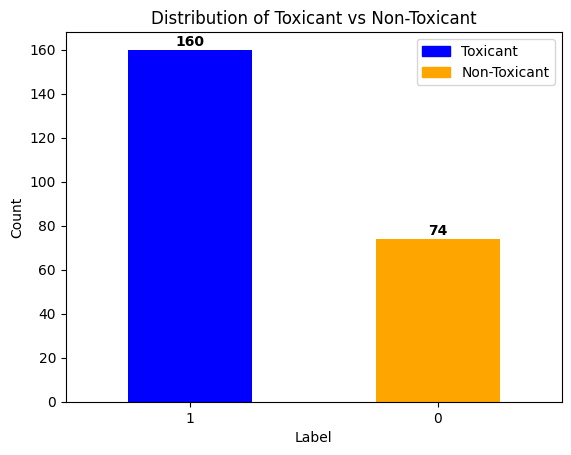

In [128]:
import matplotlib.pyplot as plt

# Data Distribution
label_counts = devtox_df['Experimental Values'].value_counts()

# Defining colors with mapping (1 = Toxicant, 0 = Non-Toxicant)
colors = ['blue' if idx == 1 else 'orange' for idx in label_counts.index]
labels_map = {1: "Toxicant", 0: "Non-Toxicant"}

# Plotting the distribution
ax = label_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Toxicant vs Non-Toxicant')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Adding counts on top of bars
for i, v in enumerate(label_counts.values):
    plt.text(i, v + 2, str(v), ha='center', fontweight='bold')

# Adding legend using custom patches
import matplotlib.patches as mpatches
toxic_patch = mpatches.Patch(color='blue', label='Toxicant')
nontoxic_patch = mpatches.Patch(color='orange', label='Non-Toxicant')
plt.legend(handles=[toxic_patch, nontoxic_patch], loc="upper right")

plt.show()


### Distribution of SMILES string length

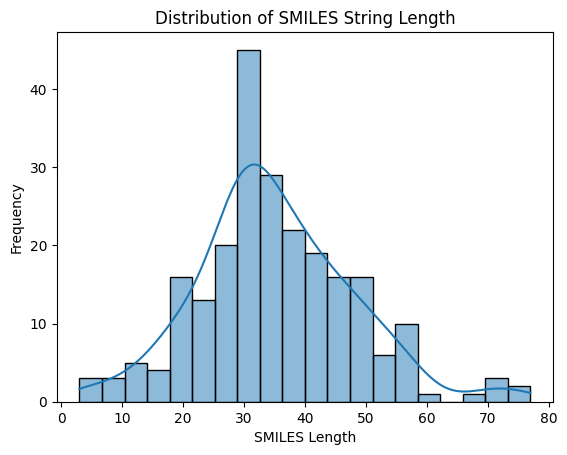

In [8]:
devtox_df['smiles_length'] = devtox_df['SMILES'].apply(len)

sns.histplot(devtox_df['smiles_length'], bins=20, kde=True)
plt.title('Distribution of SMILES String Length')
plt.xlabel('SMILES Length')
plt.ylabel('Frequency')
plt.show()


### Compute Additional Molecular Descriptors

In [112]:
from rdkit.Chem import Descriptors
# Converting SMILES to RDKit Mol object
devtox_df['mol'] = devtox_df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x))

devtox_df['TPSA'] = devtox_df['mol'].apply(Descriptors.TPSA)                   # Topological Polar Surface Area
devtox_df['NumRotatableBonds'] = devtox_df['mol'].apply(Descriptors.NumRotatableBonds)
devtox_df['RingCount'] = devtox_df['mol'].apply(Descriptors.RingCount)
devtox_df['HeavyAtomCount'] = devtox_df['mol'].apply(Descriptors.HeavyAtomCount)
devtox_df['FractionCSP3'] = devtox_df['mol'].apply(Descriptors.FractionCSP3)


### Visualize Molecular Descriptors

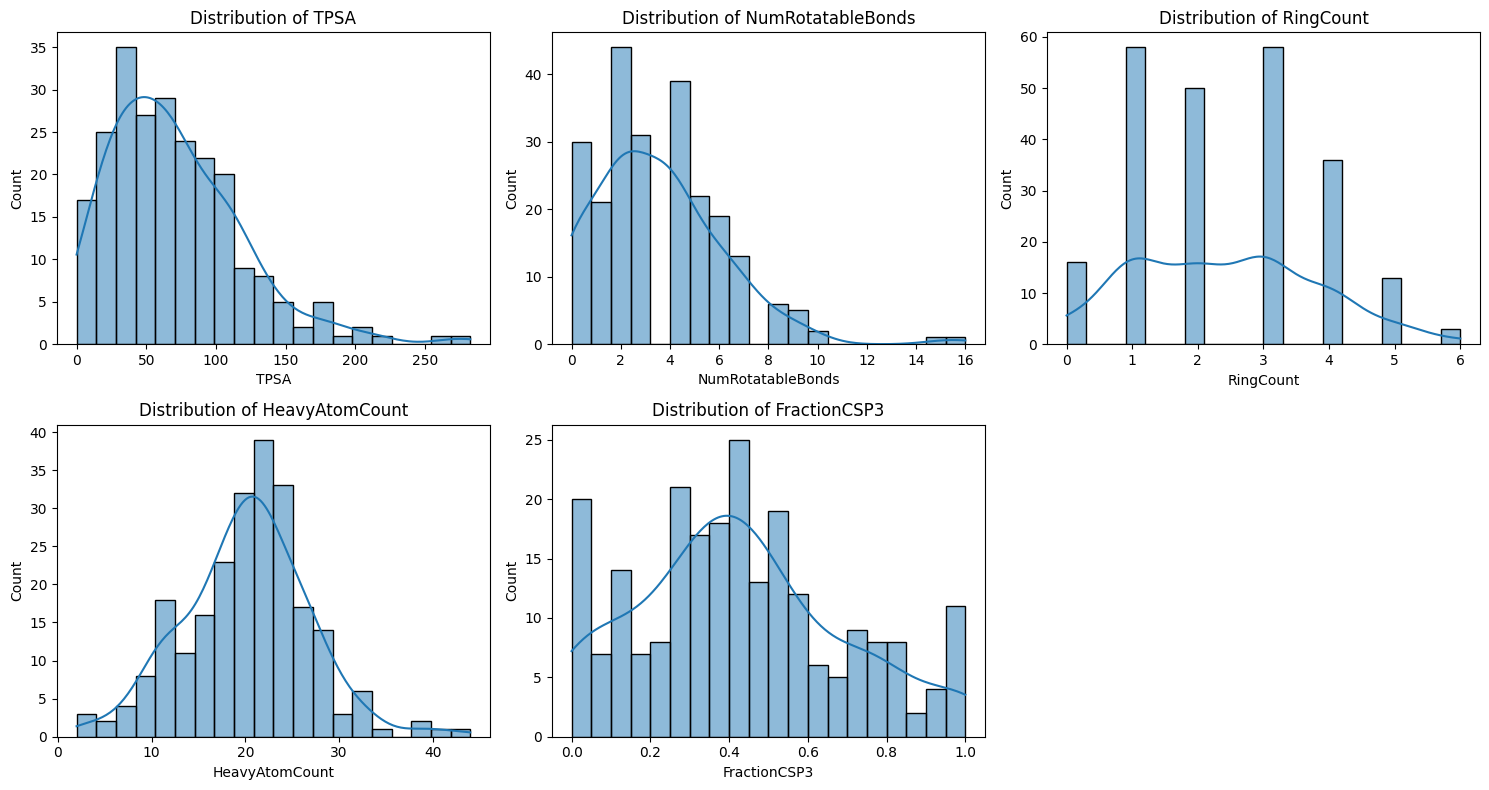

In [114]:
features = ['TPSA', 'NumRotatableBonds', 'RingCount', 'HeavyAtomCount', 'FractionCSP3']

# Creating grid with enough axes
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flatten()  # flatten to 1D for easy indexing

# Plotting only for existing features
for i, feature in enumerate(features):
    sns.histplot(devtox_df[feature], bins=20, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)

# Hiding any unused subplots
for j in range(len(features), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


### Tanimoto Similarity Index

In [100]:
# Generating Morgan Fingerprints
fingerprints = [
    AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    for mol in devtox_df['mol']
]

# Computing all pairwise similarities
similarities = []

n = len(fingerprints)
for i in range(n):
    sims = DataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints[i+1:])
    similarities.extend(sims)  # Avoid duplicate and self-comparison

# Converting to NumPy array
similarities = np.array(similarities)

# Summary statistics
total_comparisons = len(similarities)
min_sim = np.min(similarities)
max_sim = np.max(similarities)
mean_sim = np.mean(similarities)
median_sim = np.median(similarities)

# Printing the results
print(f"🔎 Tanimoto Similarity Summary (excluding self-pairs):")
print(f"➡️ Mean similarity:    {mean_sim:.3f}")


🔎 Tanimoto Similarity Summary (excluding self-pairs):
➡️ Mean similarity:    0.106


[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerator
[09:36:31] DEPRECATION WARNING: please use MorganGenerat

### Heatmap

[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerator
[20:50:19] DEPRECATION WARNING: please use MorganGenerat

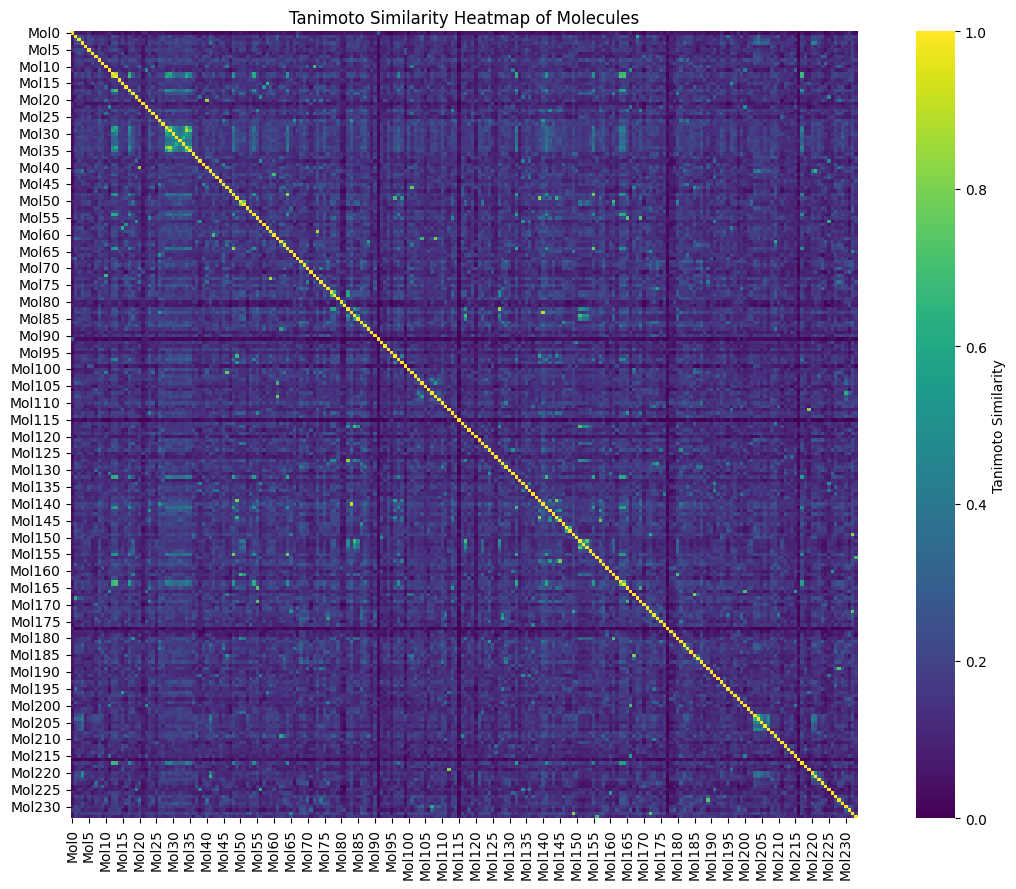

In [115]:
from rdkit import Chem

# Creating a "mol" column from SMILES
devtox_df["mol"] = devtox_df["SMILES"].apply(Chem.MolFromSmiles)

from rdkit.Chem import AllChem, DataStructs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generating Morgan Fingerprints
fingerprints = [
    AllChem.GetMorganFingerprintAsBitVect(m, radius=2, nBits=256)
    for m in devtox_df["mol"] if m is not None
]

# Creating NxN similarity matrix
n = len(fingerprints)
sim_matrix = np.zeros((n, n))

for i in range(n):
    sims = DataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints)
    sim_matrix[i, :] = sims

# Converting to DataFrame
sim_df = pd.DataFrame(
    sim_matrix,
    index=[f"Mol{i}" for i in range(n)],
    columns=[f"Mol{i}" for i in range(n)]
)

# Plotting heatmap
plt.figure(figsize=(12, 9))
sns.heatmap(sim_df, cmap="viridis", square=True, cbar_kws={"label": "Tanimoto Similarity"})
plt.title("Tanimoto Similarity Heatmap of Molecules")
plt.tight_layout()
plt.show()


### Graph Topology Analysis

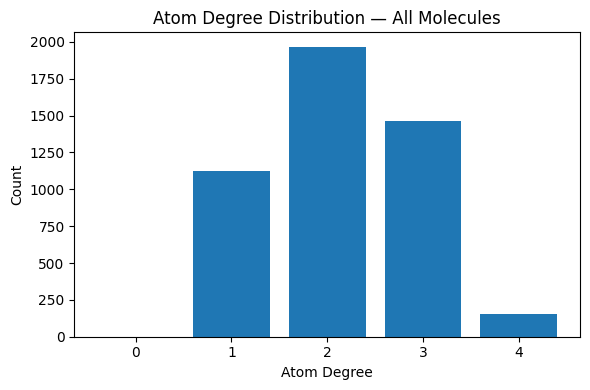

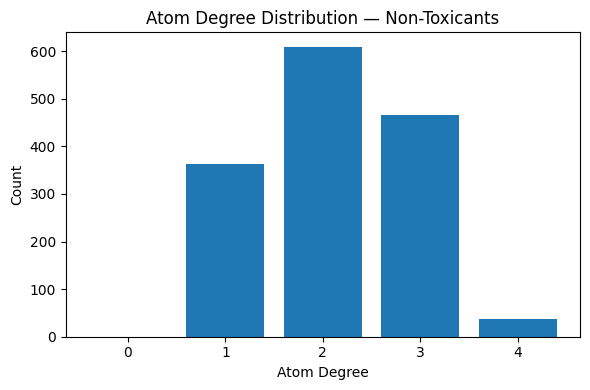

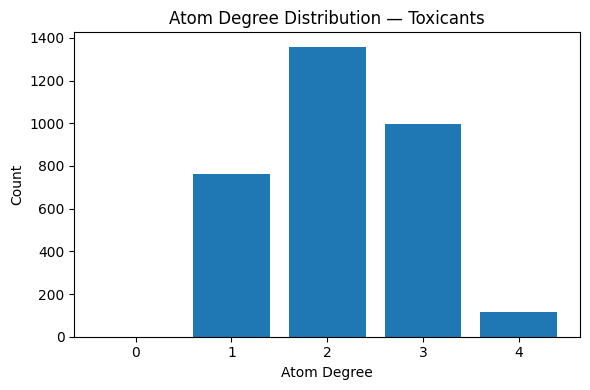

C:\Users\ayush\AppData\Local\Temp\ipykernel_3828\3358263097.py:106: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0, g1], labels=["Non-Toxicant (0)","Toxicant (1)"], showfliers=True)


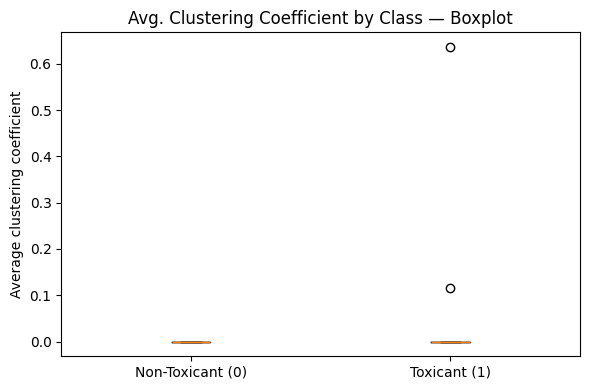

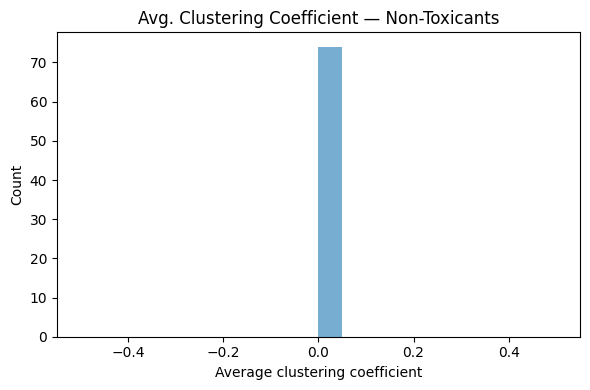

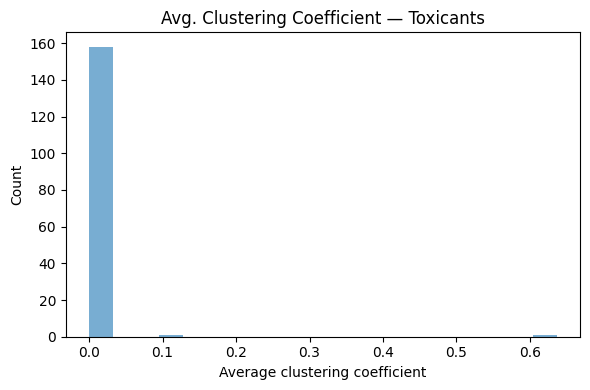

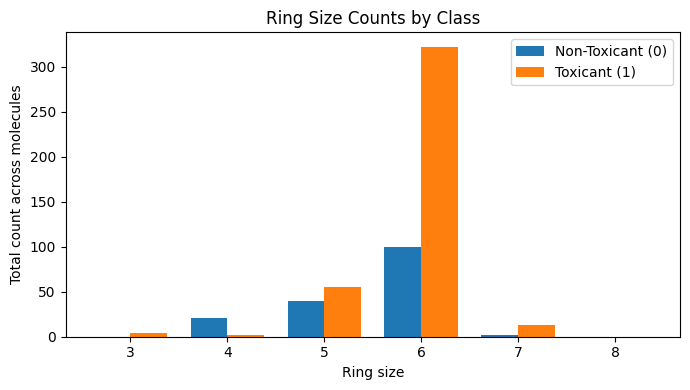

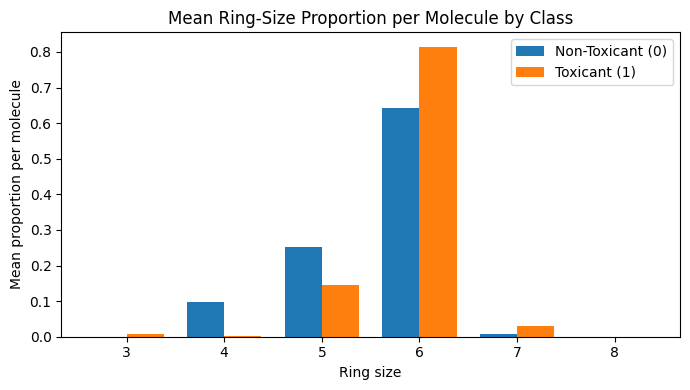

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from rdkit import Chem
from rdkit.Chem import rdmolops

# Ensuring 'label' exists
if "label" not in devtox_df.columns and "Experimental Values" in devtox_df.columns:
    devtox_df["label"] = devtox_df["Experimental Values"]

# ---------- Helpers ----------
def mol_from_smiles(s):
    try:
        return Chem.MolFromSmiles(str(s))
    except:
        return None

def degrees_from_mol(mol):
    # list of atomic degrees for one molecule
    return [a.GetDegree() for a in mol.GetAtoms()]

def avg_clustering_from_mol(mol):
    # build simple graph from adjacency matrix
    adj = rdmolops.GetAdjacencyMatrix(mol)
    G = nx.from_numpy_array(adj)  # undirected simple graph
    # average clustering coefficient over nodes
    return float(nx.average_clustering(G)) if len(G) > 0 else np.nan

def ring_size_counts_from_mol(mol, sizes=range(3, 9)):
    # count rings of each size (3..8 by default)
    ri = mol.GetRingInfo()
    counts = dict.fromkeys(sizes, 0)
    for ring in ri.AtomRings():
        L = len(ring)
        if L in counts:
            counts[L] += 1
    return counts

# ---------- Building per-molecule topology metrics ----------
mols = devtox_df["SMILES"].map(mol_from_smiles)
valid_mask = mols.notnull()
mols_valid = mols[valid_mask]

# Degree lists (flattened + per-class)
deg_all, deg_non, deg_tox = [], [], []
avg_clustering_list = []
ring_rows = []

labels_valid = devtox_df.loc[valid_mask, "label"].values

for i, mol in enumerate(mols_valid):
    # degrees for this molecule
    degs = degrees_from_mol(mol)
    deg_all.extend(degs)
    if labels_valid[i] == 0:
        deg_non.extend(degs)
    else:
        deg_tox.extend(degs)

    # average clustering for this molecule
    avg_c = avg_clustering_from_mol(mol)
    avg_clustering_list.append(avg_c)

    # ring-size counts
    ring_rows.append(ring_size_counts_from_mol(mol))

# attaching avg clustering back to dataframe (align by valid_mask)
devtox_df.loc[valid_mask, "avg_clustering_coef"] = avg_clustering_list

ring_df = pd.DataFrame(ring_rows, index=devtox_df.index[valid_mask]).fillna(0).astype(int)
# columns like 3,4,5,... for ring sizes
for c in ring_df.columns:
    devtox_df.loc[ring_df.index, f"ring_size_{c}"] = ring_df[c]

# ---------- 1) Atom degree distributions ----------
def plot_degree_hist(vals, title):
    if len(vals) == 0:
        print(f"[skip] {title}: no data")
        return
    plt.figure(figsize=(6,4))
    bins = range(0, int(max(vals)) + 2)
    plt.hist(vals, bins=bins, align="left", rwidth=0.8)
    plt.xlabel("Atom Degree"); plt.ylabel("Count"); plt.title(title)
    plt.tight_layout(); plt.show()

plot_degree_hist(deg_all, "Atom Degree Distribution — All Molecules")
plot_degree_hist(deg_non, "Atom Degree Distribution — Non-Toxicants")
plot_degree_hist(deg_tox, "Atom Degree Distribution — Toxicants")

# ---------- 2) Average clustering coefficient by class ----------
for cls, name in [(0, "Non-Toxicant (0)"), (1, "Toxicant (1)")]:
    vals = devtox_df.loc[(devtox_df["label"] == cls) & (devtox_df["avg_clustering_coef"].notna()),
                         "avg_clustering_coef"].to_numpy()
    if vals.size == 0:
        print(f"[skip] avg_clustering_coef: no data for class {cls}")
        continue

# Boxplot per class
g0 = devtox_df.loc[devtox_df["label"]==0, "avg_clustering_coef"].dropna().to_numpy()
g1 = devtox_df.loc[devtox_df["label"]==1, "avg_clustering_coef"].dropna().to_numpy()

plt.figure(figsize=(6,4))
plt.boxplot([g0, g1], labels=["Non-Toxicant (0)","Toxicant (1)"], showfliers=True)
plt.ylabel("Average clustering coefficient")
plt.title("Avg. Clustering Coefficient by Class — Boxplot")
plt.tight_layout(); plt.show()

# Histogram overlay (separate figures)
plt.figure(figsize=(6,4))
plt.hist(g0, bins=20, alpha=0.6)
plt.xlabel("Average clustering coefficient"); plt.ylabel("Count")
plt.title("Avg. Clustering Coefficient — Non-Toxicants")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.hist(g1, bins=20, alpha=0.6)
plt.xlabel("Average clustering coefficient"); plt.ylabel("Count")
plt.title("Avg. Clustering Coefficient — Toxicants")
plt.tight_layout(); plt.show()

# ---------- 3) Ring size analysis ----------
# (a) Total ring counts by size, split by class
sizes = [c for c in range(3,9) if f"ring_size_{c}" in devtox_df.columns]

sum_non = [devtox_df.loc[devtox_df["label"]==0, f"ring_size_{s}"].fillna(0).sum() for s in sizes]
sum_tox = [devtox_df.loc[devtox_df["label"]==1, f"ring_size_{s}"].fillna(0).sum() for s in sizes]

x = np.arange(len(sizes))
width = 0.38

plt.figure(figsize=(7,4))
plt.bar(x - width/2, sum_non, width, label="Non-Toxicant (0)")
plt.bar(x + width/2, sum_tox, width, label="Toxicant (1)")
plt.xticks(x, [str(s) for s in sizes])
plt.xlabel("Ring size"); plt.ylabel("Total count across molecules")
plt.title("Ring Size Counts by Class")
plt.legend()
plt.tight_layout(); plt.show()

# (b) Per-molecule normalized ring profile (proportion of rings of each size),
#     then comparing class-wise means
norm_rows_non, norm_rows_tox = [], []
for idx, row in devtox_df.iterrows():
    counts = [row.get(f"ring_size_{s}", 0) for s in sizes]
    total = sum(counts)
    if total <= 0:
        continue
    props = [c/total for c in counts]
    if row["label"] == 0:
        norm_rows_non.append(props)
    else:
        norm_rows_tox.append(props)

mean_non = np.nanmean(np.array(norm_rows_non), axis=0) if len(norm_rows_non)>0 else np.zeros(len(sizes))
mean_tox = np.nanmean(np.array(norm_rows_tox), axis=0) if len(norm_rows_tox)>0 else np.zeros(len(sizes))

plt.figure(figsize=(7,4))
plt.bar(x - width/2, mean_non, width, label="Non-Toxicant (0)")
plt.bar(x + width/2, mean_tox, width, label="Toxicant (1)")
plt.xticks(x, [str(s) for s in sizes])
plt.xlabel("Ring size"); plt.ylabel("Mean proportion per molecule")
plt.title("Mean Ring-Size Proportion per Molecule by Class")
plt.legend()
plt.tight_layout(); plt.show()


In [13]:
print(f"Unique values in 'Experimental Values':\n{devtox_df['Experimental Values'].unique()}")

Unique values in 'Experimental Values':
[0 1]


In [14]:
devtox_df.head()

,SMILES,Experimental Values,smiles_length,mol,TPSA,NumRotatableBonds,RingCount,HeavyAtomCount,FractionCSP3
0,CC=O,0,4,<rdkit.Chem.rdchem.Mol object at 0x000001E1D85...,17.07,0,0,3,0.500000
1,CC(=O)Nc1ccc(O)cc1,0,18,<rdkit.Chem.rdchem.Mol object at 0x000001E1D85...,49.33,1,1,11,0.125000
2,CC(=O)Nc1nnc(S(N)(=O)=O)s1,1,26,<rdkit.Chem.rdchem.Mol object at 0x000001E1D85...,115.04,2,1,13,0.250000
3,CC(=O)c1ccc(S(=O)(=O)NC(=O)NC2CCCCC2)cc1,1,40,<rdkit.Chem.rdchem.Mol object at 0x000001E1D85...,92.34,4,2,22,0.466667
4,CC(C=CC1=C(C)CCCC1(C)C)=CC=CC(C)=CC(=O)O,1,40,<rdkit.Chem.rdchem.Mol object at 0x000001E1D85...,37.30,5,1,22,0.450000


### Class Imbalance

Using descriptors: ['TPSA', 'NumRotatableBonds', 'RingCount', 'HeavyAtomCount', 'smiles_length']


,No. of Molecules,Percentage
Developmental Toxicity,,
Non-Toxicant (0),74,31.62
Toxicant (1),160,68.38


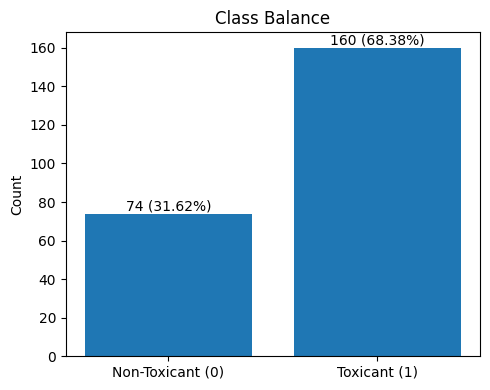

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensuring label exists (0/1)
if "label" not in devtox_df.columns and "Experimental Values" in devtox_df.columns:
    devtox_df["label"] = devtox_df["Experimental Values"]

# Making SMILES length if missing
if "smiles_length" not in devtox_df.columns and "SMILES" in devtox_df.columns:
    devtox_df["smiles_length"] = devtox_df["SMILES"].astype(str).str.len()

# Picking descriptor columns that actually exist
candidate_desc = ["TPSA", "MolWt", "NumRotatableBonds", "RingCount", 
                  "HeavyAtomCount", "NumHAcceptors", "NumHDonors", "smiles_length"]
descriptors = [c for c in candidate_desc if c in devtox_df.columns]

print("Using descriptors:", descriptors)

# Counts
counts = devtox_df["label"].value_counts().sort_index()
# Percentages
perc = (counts / counts.sum() * 100).round(2)

# Table
class_balance_df = pd.DataFrame({
    "No. of Molecules": counts,
    "Percentage": perc
}).rename(index={0:"Non-Toxicant (0)", 1:"Toxicant (1)"})

# Adding a nicer header title
class_balance_df.index.name = "Developmental Toxicity"

display(class_balance_df)

# Bar plot
plt.figure(figsize=(5,4))
plt.bar(["Non-Toxicant (0)","Toxicant (1)"], counts.values)
plt.ylabel("Count"); plt.title("Class Balance")
for i, v in enumerate(counts.values):
    plt.text(i, v, f"{v} ({perc.values[i]}%)", ha="center", va="bottom")
plt.tight_layout(); plt.show()


### Descriptors Box Plot/Violin

C:\Users\ayush\AppData\Local\Temp\ipykernel_3828\1311938597.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([g0, g1], labels=labels_txt, showfliers=True)


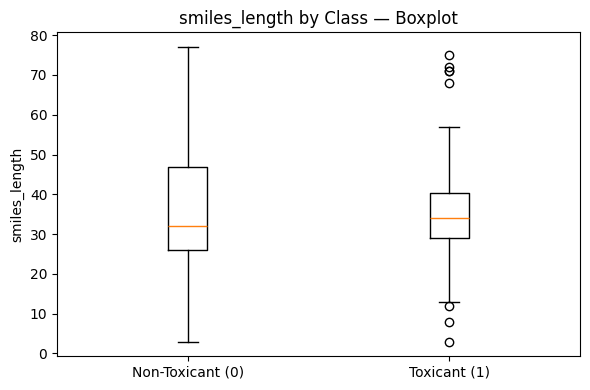

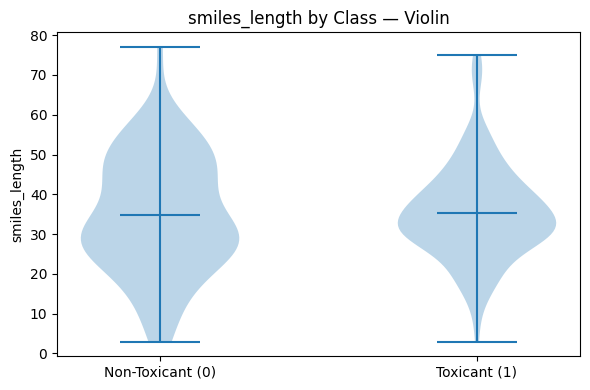

In [60]:
labels_txt = ["Non-Toxicant (0)", "Toxicant (1)"]

for feat in descriptors:
    # Preparing groups
    g0 = devtox_df.loc[devtox_df["label"]==0, feat].dropna().to_numpy()
    g1 = devtox_df.loc[devtox_df["label"]==1, feat].dropna().to_numpy()
    if g0.size==0 or g1.size==0:
        print(f"[skip] {feat}: missing data for one class")
        continue

    # Boxplot
    plt.figure(figsize=(6,4))
    plt.boxplot([g0, g1], labels=labels_txt, showfliers=True)
    plt.ylabel(feat); plt.title(f"{feat} by Class — Boxplot")
    plt.tight_layout(); plt.show()

    # Violin plot
    plt.figure(figsize=(6,4))
    parts = plt.violinplot([g0, g1], showmeans=True, showmedians=False, showextrema=True)
    # X-axis ticks
    plt.xticks([1,2], labels_txt)
    plt.ylabel(feat); plt.title(f"{feat} by Class — Violin")
    plt.tight_layout(); plt.show()


### Outliers Detection

SMILES length outliers: 8 (bounds: 4.00, 66.00)


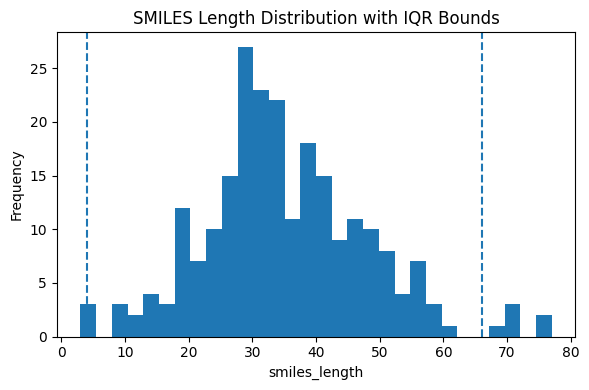

,Outliers,LowerBound(IQR),UpperBound(IQR)
Feature,,,
smiles_length,8,4.0,66.0


,Z>=3 Outliers
Feature,
smiles_length,2


In [61]:
def iqr_outliers(series, k=1.5):
    s = pd.to_numeric(series, errors="coerce").dropna()
    if s.empty: 
        return pd.Series([], dtype=int), np.nan, np.nan
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    lower = q1 - k*iqr
    upper = q3 + k*iqr
    idx = series.index[(series < lower) | (series > upper)]
    return idx, lower, upper

# a) SMILES length outliers
if "smiles_length" in devtox_df.columns:
    idx_out, low, high = iqr_outliers(devtox_df["smiles_length"])
    print(f"SMILES length outliers: {len(idx_out)} (bounds: {low:.2f}, {high:.2f})")
    # Plot with bounds
    plt.figure(figsize=(6,4))
    plt.hist(devtox_df["smiles_length"].dropna(), bins=30)
    plt.axvline(low, linestyle="--"); plt.axvline(high, linestyle="--")
    plt.xlabel("smiles_length"); plt.ylabel("Frequency")
    plt.title("SMILES Length Distribution with IQR Bounds")
    plt.tight_layout(); plt.show()

# b) Descriptor outliers (IQR) — summary table
rows = []
for feat in descriptors:
    idx_out, low, high = iqr_outliers(devtox_df[feat])
    rows.append({
        "Feature": feat,
        "Outliers": int(len(idx_out)),
        "LowerBound(IQR)": None if np.isnan(low) else round(float(low), 4),
        "UpperBound(IQR)": None if np.isnan(high) else round(float(high), 4)
    })
outlier_table = pd.DataFrame(rows).set_index("Feature")
display(outlier_table)

# c) z-score based outliers (> |z| >= 3)
def zscore_outliers(series, z=3.0):
    s = pd.to_numeric(series, errors="coerce")
    mu, sd = s.mean(), s.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return pd.Series([], dtype=int)
    zscores = (s - mu) / sd
    return s.index[zscores.abs() >= z]

rows_z = []
for feat in descriptors:
    idx = zscore_outliers(devtox_df[feat], z=3.0)
    rows_z.append({"Feature": feat, "Z>=3 Outliers": int(len(idx))})
z_outliers = pd.DataFrame(rows_z).set_index("Feature")
display(z_outliers)


### GINE Model

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, global_mean_pool
from torch_geometric.loader import DataLoader   
from torch_geometric.data import Data
from rdkit import Chem
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split

# ---------------------------
# Loading dataset

df = pd.read_csv("D:/Machine Learning Assgn/training.csv")
df['Experimental Values'] = df['Experimental Values'].astype(str).str.strip().str.replace(')', '')
df['label'] = df['Experimental Values'].map({'Toxicant': 1, 'NON-Toxicant': 0})
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

# Atom and bond feature extractors

def get_atom_features(atom):
    return torch.tensor([
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetHybridization() == Chem.rdchem.HybridizationType.SP3,
        atom.GetHybridization() == Chem.rdchem.HybridizationType.SP2,
        atom.GetHybridization() == Chem.rdchem.HybridizationType.SP,
        int(atom.GetIsAromatic()),
        atom.GetFormalCharge(),
        atom.GetNumRadicalElectrons(),
        atom.GetTotalNumHs(),
        int(atom.IsInRing())
    ], dtype=torch.float)

def get_bond_features(bond):
    return torch.tensor([
        bond.GetBondTypeAsDouble(),
        int(bond.GetIsConjugated()),
        int(bond.GetIsAromatic()),
        int(bond.IsInRing())
    ], dtype=torch.float)

def smiles_to_graph(smiles, label):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    x = torch.stack([get_atom_features(atom) for atom in mol.GetAtoms()])
    edge_index, edge_attr = [], []
    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]
        bf = get_bond_features(bond)
        edge_attr += [bf, bf]
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.stack(edge_attr) if len(edge_attr) > 0 else torch.zeros((0, 4), dtype=torch.float)
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

# Creating dataset

graph_list, labels_list = [], []
for _, row in df.iterrows():
    g = smiles_to_graph(row['SMILES'], row['label'])
    if g is not None and g.edge_index.numel() > 0:
        graph_list.append(g)
        labels_list.append(row['label'])

print(f"✅ Total graphs: {len(graph_list)}")

# Stratified train/test split

train_graphs, test_graphs = train_test_split(
    graph_list,
    test_size=0.2,
    stratify=labels_list,
    random_state=42
)

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_graphs,  batch_size=32, shuffle=False)

print(f"📦 Split -> Train: {len(train_graphs)} | Test: {len(test_graphs)}")

# Define GINE model (binary)

class GINENet(nn.Module):
    def __init__(self, in_channels, edge_in_channels, hidden_channels=64, dropout=0.2):
        super().__init__()

        def node_mlp(in_c, out_c):
            return nn.Sequential(
                nn.Linear(in_c, out_c),
                nn.ReLU(),
                nn.Linear(out_c, out_c)
            )

        self.conv1 = GINEConv(nn=node_mlp(in_channels, hidden_channels),
                              edge_dim=edge_in_channels)
        self.bn1   = nn.BatchNorm1d(hidden_channels)

        self.conv2 = GINEConv(nn=node_mlp(hidden_channels, hidden_channels),
                              edge_dim=edge_in_channels)
        self.bn2   = nn.BatchNorm1d(hidden_channels)

        self.conv3 = GINEConv(nn=node_mlp(hidden_channels, hidden_channels),
                              edge_dim=edge_in_channels)
        self.bn3   = nn.BatchNorm1d(hidden_channels)

        self.dropout = nn.Dropout(dropout)
        self.lin = nn.Linear(hidden_channels, 1)  # single logit for BCE

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x); x = F.relu(x); x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x); x = F.relu(x); x = self.dropout(x)

        x = self.conv3(x, edge_index, edge_attr)
        x = self.bn3(x); x = F.relu(x)

        x = global_mean_pool(x, batch)
        logits = self.lin(x)
        return logits

# Setup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

in_channels      = train_graphs[0].x.shape[1]
edge_in_channels = train_graphs[0].edge_attr.shape[1]
model = GINENet(in_channels, edge_in_channels, hidden_channels=64, dropout=0.2).to(device)

# BCEWithLogitsLoss with class imbalance (pos_weight = neg/pos) from TRAIN split only

train_labels = pd.Series([int(g.y.item()) for g in train_graphs]).value_counts()
num_neg = float(train_labels.get(0, 0))
num_pos = float(train_labels.get(1, 0))
pos_weight = torch.tensor([num_neg / num_pos if num_pos > 0 else 1.0], dtype=torch.float, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


# Train and evaluate

def train():
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch).squeeze(1)
        loss = criterion(logits, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step()
    return total_loss / len(train_loader)

@torch.no_grad()
def evaluate(loader, threshold=0.5):
    model.eval()
    preds, labels = [], []
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch).squeeze(1)
        probs = torch.sigmoid(logits)
        pred = (probs > threshold).long().cpu().tolist()
        lab  = batch.y.long().cpu().tolist()
        preds += pred
        labels += lab
    return balanced_accuracy_score(labels, preds), f1_score(labels, preds)


# Training loop

for epoch in range(1, 101):
    loss = train()
    ba_tr, f1_tr = evaluate(train_loader, threshold=0.5)
    ba_te, f1_te = evaluate(test_loader,  threshold=0.5)
    print(f"Epoch {epoch:03d}, Loss: {loss:.4f} | "
          f"Train BA: {ba_tr:.4f}, Train F1: {f1_tr:.4f} | "
          f"Test BA: {ba_te:.4f}, Test F1: {f1_te:.4f}")


✅ Total graphs: 234
📦 Split -> Train: 187 | Test: 47
Epoch 001, Loss: 0.4488 | Train BA: 0.5359, Train F1: 0.8079 | Test BA: 0.5333, Test F1: 0.8205
Epoch 002, Loss: 0.4051 | Train BA: 0.5288, Train F1: 0.7554 | Test BA: 0.4552, Test F1: 0.7397
Epoch 003, Loss: 0.3841 | Train BA: 0.7008, Train F1: 0.8662 | Test BA: 0.6000, Test F1: 0.8421
Epoch 004, Loss: 0.3730 | Train BA: 0.7001, Train F1: 0.8711 | Test BA: 0.6000, Test F1: 0.8421
Epoch 005, Loss: 0.3499 | Train BA: 0.7621, Train F1: 0.8731 | Test BA: 0.7198, Test F1: 0.8529
Epoch 006, Loss: 0.3319 | Train BA: 0.7804, Train F1: 0.8692 | Test BA: 0.7396, Test F1: 0.8254
Epoch 007, Loss: 0.3181 | Train BA: 0.6552, Train F1: 0.8421 | Test BA: 0.6354, Test F1: 0.8333
Epoch 008, Loss: 0.3083 | Train BA: 0.6938, Train F1: 0.7718 | Test BA: 0.6792, Test F1: 0.7143
Epoch 009, Loss: 0.2883 | Train BA: 0.8144, Train F1: 0.8439 | Test BA: 0.7260, Test F1: 0.7797
Epoch 010, Loss: 0.2956 | Train BA: 0.7050, Train F1: 0.6211 | Test BA: 0.6677, Tes

### Hyperparameter tuning

In [17]:
# Optuna tuning for GINENet

import optuna
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, f1_score
from torch_geometric.loader import DataLoader  # modern import
import torch
import torch.nn as nn

def train_one_epoch(model, loader, optimizer, criterion, device, scheduler=None):
    model.train()
    total_loss = 0.0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(batch).squeeze(1)
        loss = criterion(logits, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if scheduler is not None:
        scheduler.step()
    return total_loss / max(1, len(loader))

@torch.no_grad()
def eval_loader(model, loader, device, threshold=0.5):
    model.eval()
    preds, labels = [], []
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch).squeeze(1)
        probs = torch.sigmoid(logits)
        preds += (probs > threshold).long().cpu().tolist()
        labels += batch.y.long().cpu().tolist()
    ba = balanced_accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return ba, f1

# Labels from *train* split only
y_train_all = np.array([int(g.y.item()) for g in train_graphs])

def objective(trial):
    # ---- search space ----
    hidden_channels = trial.suggest_categorical("hidden_channels", [32, 64, 128])
    dropout         = trial.suggest_float("dropout", 0.0, 0.6)
    lr              = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    weight_decay    = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size      = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs          = 40  # short but enough to see trends
    patience        = 6   # early stopping patience (by val BA)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_balacc = []

    for tr_idx, va_idx in skf.split(np.zeros_like(y_train_all), y_train_all):
        tr_graphs = [train_graphs[i] for i in tr_idx]
        va_graphs = [train_graphs[i] for i in va_idx]

        # pos_weight from this fold’s train labels
        y_tr = [int(g.y.item()) for g in tr_graphs]
        num_neg = float(y_tr.count(0))
        num_pos = float(y_tr.count(1))
        pos_weight = torch.tensor([num_neg / num_pos if num_pos > 0 else 1.0],
                                  dtype=torch.float, device=device)

        tr_loader = DataLoader(tr_graphs, batch_size=batch_size, shuffle=True)
        va_loader = DataLoader(va_graphs, batch_size=batch_size, shuffle=False)

        in_channels      = tr_graphs[0].x.shape[1]
        edge_in_channels = tr_graphs[0].edge_attr.shape[1]

        model = GINENet(in_channels=in_channels,
                        edge_in_channels=edge_in_channels,
                        hidden_channels=hidden_channels,
                        dropout=dropout).to(device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

        best_ba = -1.0
        wait    = 0

        for _ in range(epochs):
            train_one_epoch(model, tr_loader, optimizer, criterion, device, scheduler)
            ba_val, _ = eval_loader(model, va_loader, device, threshold=0.5)

            if ba_val > best_ba:
                best_ba = ba_val
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    break

        # loading best for that fold before scoring
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
        ba_val, _ = eval_loader(model, va_loader, device, threshold=0.5)
        fold_balacc.append(ba_val)

        # pruning for speed
        trial.report(np.mean(fold_balacc), step=len(fold_balacc))
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(fold_balacc))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40, show_progress_bar=False)

print("✅ Best Mean Balanced Accuracy:", study.best_value)
print("✨ Best Hyperparameters:", study.best_params)

best_params = study.best_params


[I 2025-08-14 01:33:44,473] A new study created in memory with name: no-name-f795ae67-c687-4d71-a703-2a7be0eb2942
[I 2025-08-14 01:34:04,596] Trial 0 finished with value: 0.7321445221445222 and parameters: {'hidden_channels': 64, 'dropout': 0.07531090061792008, 'lr': 0.0030810205249041126, 'weight_decay': 3.874120187641628e-06, 'batch_size': 16}. Best is trial 0 with value: 0.7321445221445222.
[I 2025-08-14 01:34:11,666] Trial 1 finished with value: 0.5927832167832168 and parameters: {'hidden_channels': 32, 'dropout': 0.4738192988739071, 'lr': 0.00010713586809701654, 'weight_decay': 7.646081646383423e-05, 'batch_size': 32}. Best is trial 0 with value: 0.7321445221445222.
[I 2025-08-14 01:34:16,356] Trial 2 finished with value: 0.6316666666666666 and parameters: {'hidden_channels': 32, 'dropout': 0.2985372376668605, 'lr': 0.000605764480014078, 'weight_decay': 1.9131460030180562e-05, 'batch_size': 64}. Best is trial 0 with value: 0.7321445221445222.
[I 2025-08-14 01:34:22,916] Trial 3 fi

✅ Best Mean Balanced Accuracy: 0.7811002331002331
✨ Best Hyperparameters: {'hidden_channels': 128, 'dropout': 0.46748133456908864, 'lr': 0.0004942843779883342, 'weight_decay': 3.261956153820099e-05, 'batch_size': 32}


### 5 fold cross validation

In [83]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, roc_auc_score, precision_recall_curve,
    auc as sk_auc, matthews_corrcoef, precision_score, recall_score, confusion_matrix
)
from torch_geometric.loader import DataLoader

# Best hyperparameters found
best_hidden_channels = 128
best_dropout         = 0.46748133456908864
best_lr              = 0.0004942843779883342
best_weight_decay    = 3.261956153820099e-05
best_batch_size      = 32
epochs               = 60
patience             = 8

def train_one_epoch(model, loader, optimizer, criterion, device, scheduler=None):
    model.train()
    total_loss = 0.0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(batch).squeeze(1)
        loss = criterion(logits, batch.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if scheduler is not None:
        scheduler.step()
    return total_loss / max(1, len(loader))

@torch.no_grad()
def predict_loader(model, loader, device):
    """Return probs and labels."""
    model.eval()
    probs_all, labels_all = [], []
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch).squeeze(1)
        probs  = torch.sigmoid(logits).cpu().numpy()
        labels = batch.y.cpu().numpy().astype(int)
        probs_all.extend(probs.tolist())
        labels_all.extend(labels.tolist())
    return np.array(probs_all), np.array(labels_all)

def metrics_from_probs_labels(probs, labels, thr=0.5):
    preds = (probs > thr).astype(int)
    ba   = balanced_accuracy_score(labels, preds)
    f1   = f1_score(labels, preds, zero_division=0)
    mcc  = matthews_corrcoef(labels, preds) if len(np.unique(labels)) > 1 and len(np.unique(preds)) > 1 else 0.0
    prec = precision_score(labels, preds, zero_division=0)
    rec  = recall_score(labels, preds, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(labels, preds, labels=[0,1]).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    try:
        roc = roc_auc_score(labels, probs)
    except ValueError:
        roc = float("nan")
    prec_curve, rec_curve, _ = precision_recall_curve(labels, probs)
    pr_auc = sk_auc(rec_curve, prec_curve)
    return {
        "BA": ba, "F1": f1, "MCC": mcc, "Precision": prec, "Recall": rec,
        "Specificity": spec, "ROC_AUC": roc, "PR_AUC": pr_auc,
        "CM": (int(tn), int(fp), int(fn), int(tp)),
        "thr": thr
    }

# 5-fold CV on TRAIN SPLIT 

y_all = np.array([int(g.y.item()) for g in train_graphs])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# metric collectors
fold_ba, fold_f1, fold_auc = [], [], []
fold_mcc, fold_prec, fold_rec, fold_spec, fold_pr_auc = [], [], [], [], []

pooled_val_probs, pooled_val_labels = [], []

print("🔁 Starting GINE 5-fold CV with fixed best params...")
for fold, (tr_idx, va_idx) in enumerate(skf.split(np.zeros_like(y_all), y_all), start=1):
    tr_graphs = [train_graphs[i] for i in tr_idx]
    va_graphs = [train_graphs[i] for i in va_idx]

    # pos_weight from this fold's train
    y_tr = [int(g.y.item()) for g in tr_graphs]
    num_neg = float(y_tr.count(0))
    num_pos = float(y_tr.count(1))
    pos_weight = torch.tensor([num_neg / num_pos if num_pos > 0 else 1.0],
                              dtype=torch.float, device=device)

    tr_loader = DataLoader(tr_graphs, batch_size=best_batch_size, shuffle=True)
    va_loader = DataLoader(va_graphs, batch_size=best_batch_size, shuffle=False)

    in_channels      = tr_graphs[0].x.shape[1]
    edge_in_channels = tr_graphs[0].edge_attr.shape[1]

    model = GINENet(
        in_channels=in_channels,
        edge_in_channels=edge_in_channels,
        hidden_channels=best_hidden_channels,
        dropout=best_dropout
    ).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    best_ba, wait = -1.0, 0
    best_state = None

    for ep in range(1, epochs + 1):
        loss = train_one_epoch(model, tr_loader, optimizer, criterion, device, scheduler)
        # Evaluate at 0.5 for early-stopping signal
        va_probs, va_labels = predict_loader(model, va_loader, device)
        va_ba = balanced_accuracy_score(va_labels, (va_probs > 0.5).astype(int))

        print(f"Fold {fold:02d} | Epoch {ep:03d} | Loss {loss:.4f} | VA BA {va_ba:.4f}")

        if va_ba > best_ba:
            best_ba = va_ba
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"⛔ Early stopping at epoch {ep}. Best VA BA: {best_ba:.4f}")
                break

    # Loading best and compute final fold metrics (threshold 0.5 for reporting)
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    va_probs, va_labels = predict_loader(model, va_loader, device)
    pooled_val_probs.append(va_probs)
    pooled_val_labels.append(va_labels)

    # Metrics
    m = metrics_from_probs_labels(va_probs, va_labels, thr=0.5)
    fold_ba.append(m["BA"]); fold_f1.append(m["F1"]); fold_auc.append(m["ROC_AUC"])
    fold_mcc.append(m["MCC"]); fold_prec.append(m["Precision"]); fold_rec.append(m["Recall"])
    fold_spec.append(m["Specificity"]); fold_pr_auc.append(m["PR_AUC"])

    print(f"✅ Fold {fold} done | VA BA {m['BA']:.4f} | F1 {m['F1']:.4f} | AUC {m['ROC_AUC']:.4f}\n")

# CV summary
print("📊 5-Fold CV Summary (Validation @0.5):")
print(f"Balanced Accuracy: {np.nanmean(fold_ba):.4f} ± {np.nanstd(fold_ba):.4f}")
print(f"F1 Score:          {np.nanmean(fold_f1):.4f} ± {np.nanstd(fold_f1):.4f}")
print(f"ROC AUC:           {np.nanmean(fold_auc):.4f} ± {np.nanstd(fold_auc):.4f}")
print(f"MCC:               {np.nanmean(fold_mcc):.4f} ± {np.nanstd(fold_mcc):.4f}")
print(f"Precision:         {np.nanmean(fold_prec):.4f} ± {np.nanstd(fold_prec):.4f}")
print(f"Recall (Sens.):    {np.nanmean(fold_rec):.4f} ± {np.nanstd(fold_rec):.4f}")
print(f"Specificity:       {np.nanmean(fold_spec):.4f} ± {np.nanstd(fold_spec):.4f}")
print(f"PR  AUC:           {np.nanmean(fold_pr_auc):.4f} ± {np.nanstd(fold_pr_auc):.4f}")


🔁 Starting GINE 5-fold CV with fixed best params...
Fold 01 | Epoch 001 | Loss 0.4388 | VA BA 0.6186
Fold 01 | Epoch 002 | Loss 0.4298 | VA BA 0.6090
Fold 01 | Epoch 003 | Loss 0.4038 | VA BA 0.6538
Fold 01 | Epoch 004 | Loss 0.3916 | VA BA 0.8205
Fold 01 | Epoch 005 | Loss 0.3847 | VA BA 0.8365
Fold 01 | Epoch 006 | Loss 0.3704 | VA BA 0.6699
Fold 01 | Epoch 007 | Loss 0.3594 | VA BA 0.5449
Fold 01 | Epoch 008 | Loss 0.3519 | VA BA 0.6699
Fold 01 | Epoch 009 | Loss 0.3464 | VA BA 0.7564
Fold 01 | Epoch 010 | Loss 0.3274 | VA BA 0.7115
Fold 01 | Epoch 011 | Loss 0.3425 | VA BA 0.7564
Fold 01 | Epoch 012 | Loss 0.3411 | VA BA 0.6795
Fold 01 | Epoch 013 | Loss 0.3166 | VA BA 0.6314
⛔ Early stopping at epoch 13. Best VA BA: 0.8365
✅ Fold 1 done | VA BA 0.8365 | F1 0.9057 | AUC 0.8782

Fold 02 | Epoch 001 | Loss 0.4335 | VA BA 0.4808
Fold 02 | Epoch 002 | Loss 0.4102 | VA BA 0.4808
Fold 02 | Epoch 003 | Loss 0.3998 | VA BA 0.5000
Fold 02 | Epoch 004 | Loss 0.3880 | VA BA 0.4808
Fold 02 | E

### Threshold sweep

In [19]:
pooled_val_probs = np.concatenate(pooled_val_probs, axis=0)
pooled_val_labels = np.concatenate(pooled_val_labels, axis=0)

ths = np.linspace(0.2, 0.8, 121)  # fine grid; adjust if you like
scores = []
for t in ths:
    preds = (pooled_val_probs > t).astype(int)
    ba = balanced_accuracy_score(pooled_val_labels, preds)
    f1 = f1_score(pooled_val_labels, preds, zero_division=0)
    scores.append((t, ba, f1))
scores_sorted = sorted(scores, key=lambda x: (x[1], x[2]), reverse=True)

print("\nTop thresholds (val):")
for t, ba, f1 in scores_sorted[:5]:
    print(f"  thr={t:.3f} | BA={ba:.4f} | F1={f1:.4f}")

best_thr, best_thr_ba, best_thr_f1 = scores_sorted[0]
print(f"\n✅ Chosen threshold: {best_thr:.3f} (Val BA={best_thr_ba:.4f}, Val F1={best_thr_f1:.4f})")

# PR AUC on pooled val
prec_curve, rec_curve, _ = precision_recall_curve(pooled_val_labels, pooled_val_probs)
print(f"ℹ️  Validation PR AUC: {sk_auc(rec_curve, prec_curve):.4f}")


Top thresholds (val):
  thr=0.500 | BA=0.7485 | F1=0.7966
  thr=0.495 | BA=0.7309 | F1=0.7967
  thr=0.510 | BA=0.7303 | F1=0.7556
  thr=0.505 | BA=0.7297 | F1=0.7632
  thr=0.490 | BA=0.7179 | F1=0.7951

✅ Chosen threshold: 0.500 (Val BA=0.7485, Val F1=0.7966)
ℹ️  Validation PR AUC: 0.8726


### Evaluation

In [20]:
# Building loaders with fixed params
full_tr_loader = DataLoader(train_graphs, batch_size=best_batch_size, shuffle=True)
test_loader    = DataLoader(test_graphs,  batch_size=best_batch_size, shuffle=False)

# pos_weight from full train split
y_tr_full = [int(g.y.item()) for g in train_graphs]
num_neg = float(y_tr_full.count(0)); num_pos = float(y_tr_full.count(1))
pos_weight_full = torch.tensor([num_neg / num_pos if num_pos > 0 else 1.0],
                               dtype=torch.float, device=device)

in_channels      = train_graphs[0].x.shape[1]
edge_in_channels = train_graphs[0].edge_attr.shape[1]

model_final = GINENet(
    in_channels=in_channels,
    edge_in_channels=edge_in_channels,
    hidden_channels=best_hidden_channels,
    dropout=best_dropout
).to(device)

crit_final = nn.BCEWithLogitsLoss(pos_weight=pos_weight_full)
opt_final  = torch.optim.Adam(model_final.parameters(), lr=best_lr, weight_decay=best_weight_decay)
sch_final  = torch.optim.lr_scheduler.StepLR(opt_final, step_size=20, gamma=0.5)

best_val_proxy, wait = -1.0, 0
best_state = None

# Train BA at 0.5 as a weak proxy 
for ep in range(1, epochs + 1):
    loss = train_one_epoch(model_final, full_tr_loader, opt_final, crit_final, device, sch_final)
    tr_probs, tr_labels = predict_loader(model_final, full_tr_loader, device)
    tr_ba = balanced_accuracy_score(tr_labels, (tr_probs > 0.5).astype(int))
    print(f"Final Train | Epoch {ep:03d} | Loss {loss:.4f} | Train BA {tr_ba:.4f}")
    if tr_ba > best_val_proxy:
        best_val_proxy = tr_ba
        best_state = {k: v.detach().cpu().clone() for k, v in model_final.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"⛔ Early stopping final train at epoch {ep}.")
            break

# Loading best final model and evaluate on test
model_final.load_state_dict({k: v.to(device) for k, v in best_state.items()})
test_probs, test_labels = predict_loader(model_final, test_loader, device)

# Computing full test metrics at chosen threshold
res = metrics_from_probs_labels(test_probs, test_labels, thr=best_thr)

print("\n✅ FINAL TEST METRICS (threshold from CV)")
print(f"Balanced Accuracy : {res['BA']:.4f}")
print(f"MCC               : {res['MCC']:.4f}")
print(f"F1 Score          : {res['F1']:.4f}")
print(f"Precision         : {res['Precision']:.4f}")
print(f"Recall (Sensitivity): {res['Recall']:.4f}")
print(f"Specificity       : {res['Specificity']:.4f}")
print(f"ROC AUC           : {res['ROC_AUC']:.4f}")
print(f"PR AUC            : {res['PR_AUC']:.4f}")
tn, fp, fn, tp = res["CM"]
print(f"Confusion Matrix  : TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Decision Threshold: {res['thr']:.3f}")

Final Train | Epoch 001 | Loss 0.4575 | Train BA 0.5385
Final Train | Epoch 002 | Loss 0.4247 | Train BA 0.6476
Final Train | Epoch 003 | Loss 0.3979 | Train BA 0.6294
Final Train | Epoch 004 | Loss 0.3831 | Train BA 0.7204
Final Train | Epoch 005 | Loss 0.3574 | Train BA 0.7693
Final Train | Epoch 006 | Loss 0.3448 | Train BA 0.7505
Final Train | Epoch 007 | Loss 0.3377 | Train BA 0.7576
Final Train | Epoch 008 | Loss 0.3327 | Train BA 0.6885
Final Train | Epoch 009 | Loss 0.3115 | Train BA 0.7154
Final Train | Epoch 010 | Loss 0.3167 | Train BA 0.5977
Final Train | Epoch 011 | Loss 0.3175 | Train BA 0.7642
Final Train | Epoch 012 | Loss 0.3302 | Train BA 0.7544
Final Train | Epoch 013 | Loss 0.3040 | Train BA 0.7572
⛔ Early stopping final train at epoch 13.

✅ FINAL TEST METRICS (threshold from CV)
Balanced Accuracy : 0.7552
MCC               : 0.5104
F1 Score          : 0.8438
Precision         : 0.8438
Recall (Sensitivity): 0.8438
Specificity       : 0.6667
ROC AUC           : 0.85

### Locking the pipeline

In [21]:
torch.save({
    "state_dict": model_final.state_dict(),
    "threshold": 0.500,
    "params": {
        "hidden_channels": 128,
        "dropout": 0.46748133456908864,
        "lr": 0.0004942843779883342,
        "weight_decay": 3.261956153820099e-05,
        "batch_size": 32,
    }
}, "gine_best.pt")


### MPNN Model

In [1]:
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem import rdchem
import pandas as pd
import numpy as np

# loading dataset
df = pd.read_csv("D:/Machine Learning Assgn/training.csv")

# map labels (Toxicant=1, NON-Toxicant=0)
if "Experimental Values" in df.columns:
    df["Experimental Values"] = (
        df["Experimental Values"].astype(str).str.strip().str.replace(")", "", regex=False)
    )
    df["label"] = df["Experimental Values"].map({"Toxicant": 1, "NON-Toxicant": 0})
elif "LABEL" in df.columns:
    # fallback if file uses LABEL instead
    df["label"] = df["LABEL"].map({"Toxicant": 1, "NON-Toxicant": 0})
else:
    raise ValueError("Could not find label column. Expected 'Experimental Values' or 'LABEL'.")

df = df.dropna(subset=["label"])
df["label"] = df["label"].astype(int)

# --- helper: one-hot with 'other' bucket ---
def one_hot_with_other(x, choices):
    v = [1.0 if x == c else 0.0 for c in choices]
    if x not in choices:
        v.append(1.0)  # 'other'
    else:
        v.append(0.0)
    return v

# --- atom features ---
# Common organics atom types; last dim gets 'other' bucket
COMMON_ATOMS = [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]  # H, C, N, O, F, P, S, Cl, Br, I
DEGREE_CHOICES = [0, 1, 2, 3, 4, 5]
HCOUNT_CHOICES = [0, 1, 2, 3, 4]
VALENCE_CHOICES = [0, 1, 2, 3, 4, 5, 6]
HYBRID_CHOICES = [
    rdchem.HybridizationType.SP,
    rdchem.HybridizationType.SP2,
    rdchem.HybridizationType.SP3,
    rdchem.HybridizationType.SP3D,
    rdchem.HybridizationType.SP3D2,
]

def get_atom_features(atom: rdchem.Atom) -> torch.Tensor:
    # atomic number (one-hot + other)
    v = []
    v += one_hot_with_other(atom.GetAtomicNum(), COMMON_ATOMS)

    # degree, total Hs, valence (one-hot capped ranges)
    v += one_hot_with_other(min(atom.GetDegree(), max(DEGREE_CHOICES)), DEGREE_CHOICES)
    v += one_hot_with_other(min(atom.GetTotalNumHs(), max(HCOUNT_CHOICES)), HCOUNT_CHOICES)
    v += one_hot_with_other(min(atom.GetTotalValence(), max(VALENCE_CHOICES)), VALENCE_CHOICES)

    # hybridization (one-hot with 'other')
    v += one_hot_with_other(atom.GetHybridization(), HYBRID_CHOICES)

    # aromatic, in ring, chiral flag
    v += [
        float(atom.GetIsAromatic()),
        float(atom.IsInRing()),
        float(atom.HasProp('_ChiralityPossible')),
    ]

    # formal charge (numeric, clipped to [-2, 2])
    charge = float(np.clip(atom.GetFormalCharge(), -2, 2))
    v += [charge]

    return torch.tensor(v, dtype=torch.float)

# --- bond features ---
BOND_TYPES = [
    rdchem.BondType.SINGLE,
    rdchem.BondType.DOUBLE,
    rdchem.BondType.TRIPLE,
    rdchem.BondType.AROMATIC,
]
STEREO_TYPES = [
    rdchem.BondStereo.STEREONONE,
    rdchem.BondStereo.STEREOZ,
    rdchem.BondStereo.STEREOE,
    rdchem.BondStereo.STEREOANY,
]

def get_bond_features(bond: rdchem.Bond) -> torch.Tensor:
    if bond is None:
        # for implicit/self-loops 
        return torch.zeros(len(BOND_TYPES) + 1 + 2 + len(STEREO_TYPES) + 1, dtype=torch.float)

    v = []
    # bond type (one-hot + other)
    v += one_hot_with_other(bond.GetBondType(), BOND_TYPES)

    # conjugation, ring
    v += [float(bond.GetIsConjugated()), float(bond.IsInRing())]

    # stereo (one-hot + other)
    v += one_hot_with_other(bond.GetStereo(), STEREO_TYPES)

    return torch.tensor(v, dtype=torch.float)

# --- SMILES → PyG Data ---
def smiles_to_graph(smiles: str, label: int):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # node features
    x = torch.stack([get_atom_features(a) for a in mol.GetAtoms()], dim=0)

    edge_index = []
    edge_attr = []

    # building undirected edges (i->j and j->i) with bond features
    for b in mol.GetBonds():
        i = b.GetBeginAtomIdx()
        j = b.GetEndAtomIdx()
        bf = get_bond_features(b)

        edge_index += [[i, j], [j, i]]
        edge_attr += [bf, bf]

    # skipping molecules with no bonds (NNConv/MPNN needs edges)
    if len(edge_index) == 0:
        return None

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.stack(edge_attr, dim=0)  # (num_edges, edge_feat_dim)
    y = torch.tensor([int(label)], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

# --- building PyG dataset ---
graph_list, labels_list = [], []
for _, row in df.iterrows():
    g = smiles_to_graph(row["SMILES"], row["label"])
    if g is not None:
        graph_list.append(g)
        labels_list.append(int(row["label"]))

print(f"✅ Total graphs constructed: {len(graph_list)}")
if len(graph_list) > 0:
    print(f"Node feature dim: {graph_list[0].x.size(1)} | Edge feature dim: {graph_list[0].edge_attr.size(1)}")


✅ Total graphs constructed: 234
Node feature dim: 42 | Edge feature dim: 12


### Building MPNN Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score
import numpy as np, random, pandas as pd

def set_seed(seed=42):
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
set_seed(42)

# Stratified split (uses graph_list, labels_list from Block 1)
train_graphs, test_graphs = train_test_split(
    graph_list, test_size=0.2, stratify=labels_list, random_state=42
)
print(f"📦 Split -> Train: {len(train_graphs)} | Test: {len(test_graphs)}")

# --- dataloaders (smaller batch to save RAM) ---
batch_size = 16
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_graphs,  batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== 3-layer MPNN (NNConv + GRU) with compact edge MLPs =====
class MPNN3(nn.Module):
    """
    3× (NNConv -> GRU) with BN/Dropout and residuals on layers 2 & 3.
    Edge MLPs are kept small: [edge_dim -> edge_hidden -> (in*out)].
    """
    def __init__(self, in_channels, edge_dim, hidden_channels=64, dropout=0.25, edge_hidden=64):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # ---- Layer 1: in -> hidden ----
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.edge_mlp1 = nn.Sequential(
            nn.Linear(edge_dim, edge_hidden),
            nn.ReLU(),
            nn.Linear(edge_hidden, in_channels * hidden_channels),
        )
        self.conv1 = NNConv(in_channels, hidden_channels, nn=self.edge_mlp1, aggr="mean")
        self.gru1  = nn.GRU(hidden_channels, hidden_channels)

        # ---- Layer 2: hidden -> hidden (residual) ----
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.edge_mlp2 = nn.Sequential(
            nn.Linear(edge_dim, edge_hidden),
            nn.ReLU(),
            nn.Linear(edge_hidden, hidden_channels * hidden_channels),
        )
        self.conv2 = NNConv(hidden_channels, hidden_channels, nn=self.edge_mlp2, aggr="mean")
        self.gru2  = nn.GRU(hidden_channels, hidden_channels)

        # ---- Layer 3: hidden -> hidden (residual) ----
        self.bn3 = nn.BatchNorm1d(hidden_channels)
        self.edge_mlp3 = nn.Sequential(
            nn.Linear(edge_dim, edge_hidden),
            nn.ReLU(),
            nn.Linear(edge_hidden, hidden_channels * hidden_channels),
        )
        self.conv3 = NNConv(hidden_channels, hidden_channels, nn=self.edge_mlp3, aggr="mean")
        self.gru3  = nn.GRU(hidden_channels, hidden_channels)

        # classifier head (binary logit)
        self.lin = nn.Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        # Layer 1 (no residual; dims change in->hidden)
        m1 = F.relu(self.conv1(x, edge_index, edge_attr))
        m1 = self.dropout(self.bn1(m1))
        x1, _ = self.gru1(m1.unsqueeze(0), torch.zeros(1, m1.size(0), m1.size(1), device=m1.device))
        x = x1.squeeze(0)

        # Layer 2 (residual)
        m2 = F.relu(self.conv2(x, edge_index, edge_attr))
        m2 = self.dropout(self.bn2(m2))
        x2, _ = self.gru2(m2.unsqueeze(0), x.unsqueeze(0))
        x = x + x2.squeeze(0)

        # Layer 3 (residual)
        m3 = F.relu(self.conv3(x, edge_index, edge_attr))
        m3 = self.dropout(self.bn3(m3))
        x3, _ = self.gru3(m3.unsqueeze(0), x.unsqueeze(0))
        x = x + x3.squeeze(0)

        g = global_mean_pool(x, batch)
        return self.lin(g).squeeze(1)  # (B,)

# --- instantiate model ---
in_channels = graph_list[0].x.size(1)         # e.g., 42
edge_dim    = graph_list[0].edge_attr.size(1) # e.g., 12
model = MPNN3(in_channels=in_channels, edge_dim=edge_dim,
              hidden_channels=64, dropout=0.30, edge_hidden=64).to(device)

# --- class imbalance (from TRAIN only) ---
train_counts = pd.Series([int(g.y.item()) for g in train_graphs]).value_counts()
num_neg = float(train_counts.get(0, 0)); num_pos = float(train_counts.get(1, 0))
pos_weight = torch.tensor([num_neg / num_pos if num_pos > 0 else 1.0], device=device, dtype=torch.float)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# --- optimizer & scheduler ---
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# --- train/eval helpers ---
def train_one_epoch():
    model.train(); total = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch)
        loss = criterion(logits, batch.y.float())
        loss.backward(); optimizer.step()
        total += loss.item()
    scheduler.step()
    return total / max(1, len(train_loader))

@torch.no_grad()
def evaluate(loader, thr=0.5):
    model.eval(); preds, labels = [], []
    for batch in loader:
        batch = batch.to(device)
        probs = torch.sigmoid(model(batch))
        preds += (probs > thr).long().cpu().tolist()
        labels += batch.y.long().cpu().tolist()
    return balanced_accuracy_score(labels, preds), f1_score(labels, preds)

# --- quick training loop (sanity check) ---
epochs = 50
for epoch in range(1, epochs + 1):
    loss = train_one_epoch()
    ba_tr, f1_tr = evaluate(train_loader, thr=0.5)
    ba_te, f1_te = evaluate(test_loader,  thr=0.5)
    print(f"Epoch {epoch:03d}, Loss: {loss:.4f} | "
          f"Train BA: {ba_tr:.4f}, Train F1: {f1_tr:.4f} | "
          f"Test BA: {ba_te:.4f}, Test F1: {f1_te:.4f}")


📦 Split -> Train: 187 | Test: 47
Epoch 001, Loss: 0.4311 | Train BA: 0.7323, Train F1: 0.7830 | Test BA: 0.6302, Test F1: 0.6786
Epoch 002, Loss: 0.3726 | Train BA: 0.7322, Train F1: 0.8268 | Test BA: 0.7531, Test F1: 0.8657
Epoch 003, Loss: 0.3213 | Train BA: 0.7720, Train F1: 0.8264 | Test BA: 0.7396, Test F1: 0.8254
Epoch 004, Loss: 0.3009 | Train BA: 0.8065, Train F1: 0.8740 | Test BA: 0.6885, Test F1: 0.8182
Epoch 005, Loss: 0.2932 | Train BA: 0.8007, Train F1: 0.8036 | Test BA: 0.7615, Test F1: 0.7636
Epoch 006, Loss: 0.2397 | Train BA: 0.8463, Train F1: 0.8760 | Test BA: 0.7729, Test F1: 0.8387
Epoch 007, Loss: 0.2470 | Train BA: 0.8860, Train F1: 0.9157 | Test BA: 0.7885, Test F1: 0.8571
Epoch 008, Loss: 0.2281 | Train BA: 0.8391, Train F1: 0.8608 | Test BA: 0.7594, Test F1: 0.7931
Epoch 009, Loss: 0.2454 | Train BA: 0.8833, Train F1: 0.9349 | Test BA: 0.7375, Test F1: 0.8485
Epoch 010, Loss: 0.2051 | Train BA: 0.9049, Train F1: 0.9076 | Test BA: 0.7260, Test F1: 0.7797
Epoch 0

### Hyperparameter Tuning

In [7]:
import optuna, numpy as np, torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, roc_auc_score, precision_recall_curve,
    matthews_corrcoef, precision_score, recall_score, confusion_matrix
)
from torch_geometric.loader import DataLoader
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

@torch.no_grad()
def eval_loader_probs(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        labels = batch.y.detach().cpu().numpy().astype(int)
        all_probs.extend(probs.tolist())
        all_labels.extend(labels.tolist())
    return np.asarray(all_probs), np.asarray(all_labels)

def threshold_sweep(y_true, y_prob, n=101, metric="ba"):
    thr_grid = np.linspace(0.05, 0.95, n)
    best_thr, best_ba, best_f1 = 0.5, -1.0, -1.0
    for thr in thr_grid:
        pred = (y_prob >= thr).astype(int)
        ba  = balanced_accuracy_score(y_true, pred)
        f1  = f1_score(y_true, pred) if (pred.sum() > 0) else 0.0
        if metric == "ba":
            key = ba
        else:
            key = f1
        if key > (best_ba if metric == "ba" else best_f1):
            best_thr = float(thr)
            best_ba  = ba
            best_f1  = f1
    return best_thr, best_ba, best_f1

def compute_full_metrics(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(int)
    ba = balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred) if y_pred.sum() else 0.0
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)  # sensitivity
    mcc  = matthews_corrcoef(y_true, y_pred) if len(np.unique(y_true)) > 1 and len(np.unique(y_pred)) > 1 else 0.0
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    spec = tn / (tn + fp) if (tn + fp) else 0.0
    try:
        roc = roc_auc_score(y_true, y_prob)
    except ValueError:
        roc = float("nan")
    prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = np.trapz(rec_curve, prec_curve)  # or use sklearn.metrics.auc(prec_curve, rec_curve)
    return {
        "ba": ba, "mcc": mcc, "f1": f1, "precision": prec, "recall": rec,
        "specificity": spec, "roc_auc": roc, "pr_auc": pr_auc,
        "cm": (int(tn), int(fp), int(fn), int(tp))
    }

# ---------- OPTUNA on TRAIN SPLIT ONLY ----------
y_train_all = np.array([int(g.y.item()) for g in train_graphs])

def objective(trial):
    hidden_channels = trial.suggest_categorical("hidden_channels", [48, 64, 96])
    dropout         = trial.suggest_float("dropout", 0.15, 0.5)
    edge_hidden     = trial.suggest_categorical("edge_hidden", [32, 64, 96])
    lr              = trial.suggest_float("lr", 3e-4, 3e-3, log=True)
    weight_decay    = trial.suggest_float("weight_decay", 1e-6, 5e-4, log=True)
    batch_size      = trial.suggest_categorical("batch_size", [8, 16, 32])
    epochs          = 30

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_balacc = []

    for tr_idx, va_idx in skf.split(np.zeros_like(y_train_all), y_train_all):
        tr_graphs = [train_graphs[i] for i in tr_idx]
        va_graphs = [train_graphs[i] for i in va_idx]

        # pos_weight per fold
        y_tr = [int(g.y.item()) for g in tr_graphs]
        num_neg = float(y_tr.count(0)); num_pos = float(y_tr.count(1))
        pos_weight = torch.tensor([num_neg/num_pos if num_pos>0 else 1.0], device=device, dtype=torch.float)

        tr_loader = DataLoader(tr_graphs, batch_size=batch_size, shuffle=True)
        va_loader = DataLoader(va_graphs, batch_size=batch_size, shuffle=False)

        model = MPNN3(
            in_channels=train_graphs[0].x.size(1),
            edge_dim=train_graphs[0].edge_attr.size(1),
            hidden_channels=hidden_channels,
            dropout=dropout,
            edge_hidden=edge_hidden
        ).to(device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

        # short early stopping on val BA
        best_ba, wait, patience = -1.0, 0, 5
        best_state = None

        for _ in range(epochs):
            model.train(); total = 0.0
            for batch in tr_loader:
                batch = batch.to(device)
                optimizer.zero_grad()
                logits = model(batch)
                loss = criterion(logits, batch.y.float())
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                optimizer.step()
                total += loss.item()
            scheduler.step()

            # val BA
            va_prob, va_lab = eval_loader_probs(model, va_loader)
            va_pred = (va_prob >= 0.5).astype(int)
            ba = balanced_accuracy_score(va_lab, va_pred)

            if ba > best_ba:
                best_ba = ba; wait = 0
                best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
            else:
                wait += 1
                if wait >= patience:
                    break

        fold_balacc.append(best_ba)

    return float(np.mean(fold_balacc))

print("🔎 Running Optuna for MPNN3…")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, show_progress_bar=False)
print("✅ Best Mean Balanced Accuracy:", study.best_value)
print("✨ Best Hyperparameters:", study.best_params)
best = study.best_params

[I 2025-08-16 17:20:00,377] A new study created in memory with name: no-name-82a304fe-b3c2-406a-99ee-1f1e33efb844


🔎 Running Optuna for MPNN3…


[I 2025-08-16 17:22:01,584] Trial 0 finished with value: 0.7548554778554777 and parameters: {'hidden_channels': 96, 'dropout': 0.3591595324403951, 'edge_hidden': 32, 'lr': 0.0010689213922196535, 'weight_decay': 2.444863496329527e-06, 'batch_size': 32}. Best is trial 0 with value: 0.7548554778554777.
[I 2025-08-16 17:24:28,850] Trial 1 finished with value: 0.7042027972027971 and parameters: {'hidden_channels': 96, 'dropout': 0.2419860938337429, 'edge_hidden': 64, 'lr': 0.00030938842868967985, 'weight_decay': 0.00012188243536789273, 'batch_size': 32}. Best is trial 0 with value: 0.7548554778554777.
[I 2025-08-16 17:25:54,549] Trial 2 finished with value: 0.7144965034965034 and parameters: {'hidden_channels': 64, 'dropout': 0.24128131390465876, 'edge_hidden': 96, 'lr': 0.0003052750371920058, 'weight_decay': 0.0002820339815008386, 'batch_size': 32}. Best is trial 0 with value: 0.7548554778554777.
[I 2025-08-16 17:26:47,661] Trial 3 finished with value: 0.7513682983682983 and parameters: {'

✅ Best Mean Balanced Accuracy: 0.7675221445221446
✨ Best Hyperparameters: {'hidden_channels': 96, 'dropout': 0.31308349382149525, 'edge_hidden': 32, 'lr': 0.0006225464626786211, 'weight_decay': 2.465088525762254e-05, 'batch_size': 32}


### Cross Validation

In [90]:
import numpy as np, torch, torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, roc_auc_score, precision_recall_curve,
    matthews_corrcoef, precision_score, recall_score, confusion_matrix,
    average_precision_score, auc
)
from torch_geometric.loader import DataLoader

if "best_params" not in globals():
    best_params = {
        'hidden_channels': 96,
        'dropout': 0.31308349382149525,
        'edge_hidden': 32,
        'lr': 0.0006225464626786211,
        'weight_decay': 2.465088525762254e-05,
        'batch_size': 32,
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- helpers ----------
@torch.no_grad()
def eval_loader_probs(model, loader, device):
    model.eval()
    all_probs, all_labels = [], []
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        labels = batch.y.detach().cpu().numpy().astype(int)
        all_probs.extend(probs.tolist())
        all_labels.extend(labels.tolist())
    return np.asarray(all_probs), np.asarray(all_labels)

def fold_metrics_from_probs(y_true, y_prob, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    ba = balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred) if y_pred.sum() else 0.0
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)  # sensitivity
    mcc  = matthews_corrcoef(y_true, y_pred) if len(np.unique(y_pred)) > 1 else 0.0
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    spec = tn / (tn + fp) if (tn + fp) else 0.0

    # ROC AUC (guard)
    try:
        roc = roc_auc_score(y_true, y_prob)
    except ValueError:
        roc = float("nan")

    # ----- FIXED PR AUC -----
    
    pr_auc_ap = average_precision_score(y_true, y_prob)

    # manual AUC with recall as x-axis:
    prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_prob)
    pr_auc_manual = auc(rec_curve, prec_curve)  # recall on x, precision on y

    return dict(
        ba=ba, f1=f1, precision=prec, recall=rec, specificity=spec,
        mcc=mcc, roc_auc=roc, pr_auc=pr_auc_ap, pr_auc_manual=pr_auc_manual,
        cm=(int(tn), int(fp), int(fn), int(tp))
    )

# ---------- CV loop (on TRAIN split only) ----------
y_all = np.array([int(g.y.item()) for g in train_graphs])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

fold_results = []
all_val_probs, all_val_labels = [], []

print("🔁 5-fold CV — MPNN3 with fixed best params (PR AUC fixed)")
for fold, (tr_idx, va_idx) in enumerate(skf.split(np.zeros_like(y_all), y_all), start=1):
    tr_graphs = [train_graphs[i] for i in tr_idx]
    va_graphs = [train_graphs[i] for i in va_idx]

    # pos_weight for BCE (neg/pos) from this fold's train labels
    y_tr = [int(g.y.item()) for g in tr_graphs]
    num_neg = float(y_tr.count(0)); num_pos = float(y_tr.count(1))
    pos_weight = torch.tensor([num_neg / num_pos if num_pos > 0 else 1.0],
                              dtype=torch.float, device=device)

    tr_loader = DataLoader(tr_graphs, batch_size=best_params["batch_size"], shuffle=True)
    va_loader = DataLoader(va_graphs, batch_size=best_params["batch_size"], shuffle=False)

    # model / opt / sched
    model = MPNN3(
        in_channels=train_graphs[0].x.size(1),
        edge_dim=train_graphs[0].edge_attr.size(1),
        hidden_channels=best_params["hidden_channels"],
        dropout=best_params["dropout"],
        edge_hidden=best_params["edge_hidden"],
    ).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=best_params["lr"],
                                  weight_decay=best_params["weight_decay"])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    # train with early stopping on val BA
    best_ba, wait, patience = -1.0, 0, 8
    best_state = None
    max_epochs = 60

    for epoch in range(1, max_epochs + 1):
        model.train(); total = 0.0
        for batch in tr_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            logits = model(batch)
            loss = criterion(logits, batch.y.float())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            total += loss.item()
        scheduler.step()

        # quick val check @0.5 for early stopping
        va_prob, va_lab = eval_loader_probs(model, va_loader, device)
        va_pred = (va_prob >= 0.5).astype(int)
        ba = balanced_accuracy_score(va_lab, va_pred)

        if ba > best_ba:
            best_ba = ba; wait = 0
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= patience:
                break

    # restore best model for this fold
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    # final fold metrics @0.5
    va_prob, va_lab = eval_loader_probs(model, va_loader, device)
    all_val_probs.append(va_prob); all_val_labels.append(va_lab)
    m = fold_metrics_from_probs(va_lab, va_prob, thr=0.5)
    fold_results.append(m)

    tn, fp, fn, tp = m["cm"]
    print(f"✅ Fold {fold} | BA={m['ba']:.4f} | F1={m['f1']:.4f} | MCC={m['mcc']:.4f} | "
          f"Prec={m['precision']:.4f} | Rec={m['recall']:.4f} | Spec={m['specificity']:.4f} | "
          f"PR-AUC(AP)={m['pr_auc']:.4f} | PR-AUC(manual)={m['pr_auc_manual']:.4f} | "
          f"CM: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# ----- summary across folds (threshold = 0.5) -----
def mean_std(key):
    vals = np.array([fr[key] for fr in fold_results], dtype=float)
    return float(np.nanmean(vals)), float(np.nanstd(vals))

ba_mean, ba_std = mean_std("ba")
f1_mean, f1_std = mean_std("f1")
mcc_mean, mcc_std = mean_std("mcc")
pr_mean, pr_std = mean_std("precision")
re_mean, re_std = mean_std("recall")
sp_mean, sp_std = mean_std("specificity")
pra_mean, pra_std = mean_std("pr_auc")  # AP-based PR AUC

print("\n📊 5-Fold CV Summary @ threshold=0.50")
print(f"Balanced Accuracy: {ba_mean:.4f} ± {ba_std:.4f}")
print(f"F1 Score:          {f1_mean:.4f} ± {f1_std:.4f}")
print(f"MCC:               {mcc_mean:.4f} ± {mcc_std:.4f}")
print(f"Precision:         {pr_mean:.4f} ± {pr_std:.4f}")
print(f"Recall (Sens.):    {re_mean:.4f} ± {re_std:.4f}")
print(f"Specificity:       {sp_mean:.4f} ± {sp_std:.4f}")
print(f"PR  AUC (AP):      {pra_mean:.4f} ± {pra_std:.4f}")


🔁 5-fold CV — MPNN3 with fixed best params (PR AUC fixed)
✅ Fold 1 | BA=0.8782 | F1=0.9231 | MCC=0.7564 | Prec=0.9231 | Rec=0.9231 | Spec=0.8333 | PR-AUC(AP)=0.9017 | PR-AUC(manual)=0.8983 | CM: TN=10, FP=2, FN=2, TP=24
✅ Fold 2 | BA=0.5833 | F1=0.6047 | MCC=0.1558 | Prec=0.7647 | Rec=0.5000 | Spec=0.6667 | PR-AUC(AP)=0.7109 | PR-AUC(manual)=0.6970 | CM: TN=8, FP=4, FN=13, TP=13
✅ Fold 3 | BA=0.7867 | F1=0.8627 | MCC=0.5599 | Prec=0.8800 | Rec=0.8462 | Spec=0.7273 | PR-AUC(AP)=0.8887 | PR-AUC(manual)=0.8850 | CM: TN=8, FP=3, FN=4, TP=22
✅ Fold 4 | BA=0.7983 | F1=0.7907 | MCC=0.5588 | Prec=0.9444 | Rec=0.6800 | Spec=0.9167 | PR-AUC(AP)=0.9385 | PR-AUC(manual)=0.9372 | CM: TN=11, FP=1, FN=8, TP=17
✅ Fold 5 | BA=0.8567 | F1=0.8980 | MCC=0.6995 | Prec=0.9167 | Rec=0.8800 | Spec=0.8333 | PR-AUC(AP)=0.9644 | PR-AUC(manual)=0.9636 | CM: TN=10, FP=2, FN=3, TP=22

📊 5-Fold CV Summary @ threshold=0.50
Balanced Accuracy: 0.7807 ± 0.1045
F1 Score:          0.8158 ± 0.1146
MCC:               0.5461

### Evaluation

In [72]:
# --- Safety: ensure best_params exists and has all required keys ---
required_keys = ["hidden_channels", "dropout", "edge_hidden", "lr", "weight_decay", "batch_size"]

if "best_params" not in globals():
    best_params = {}

# Filling with Optuna results
if "study" in globals():
    # merge, Optuna keys win
    best_params = {**best_params, **study.best_params}

# Providing defaults for any missing keys
defaults = {
    "hidden_channels": 96,
    "dropout": 0.30,
    "edge_hidden": 64,
    "lr": 6e-4,
    "weight_decay": 2.5e-5,
    "batch_size": 32,
}
for k, v in defaults.items():
    if k not in best_params:
        best_params[k] = v

print("Using best_params:", best_params)

# --- Safety: ensure cv_threshold is set from thr_opt (or default 0.5) ---
if "thr_opt" in globals():
    cv_threshold = float(thr_opt)
else:
    cv_threshold = 0.5
    print("Warning: thr_opt not found; using default threshold 0.5")

# ============================
# FINAL EVALUATION 

import numpy as np, torch, torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from torch_geometric.loader import DataLoader

# 1) using CV-chosen threshold
cv_threshold = float(thr_opt)

# 2) small internal val split (from TRAIN ONLY) for early stopping
y_train_all = np.array([int(g.y.item()) for g in train_graphs])
idx_tr, idx_va = train_test_split(
    np.arange(len(train_graphs)),
    test_size=0.15,
    stratify=y_train_all,
    random_state=123
)
final_tr = [train_graphs[i] for i in idx_tr]
final_va = [train_graphs[i] for i in idx_va]

tr_loader = DataLoader(final_tr, batch_size=best_params["batch_size"], shuffle=True)
va_loader = DataLoader(final_va,   batch_size=best_params["batch_size"], shuffle=False)

# 3) building fresh FINAL model with best params (from Optuna/CV)
final_model = MPNN3(
    in_channels=train_graphs[0].x.size(1),
    edge_dim=train_graphs[0].edge_attr.size(1),
    hidden_channels=best_params["hidden_channels"],
    dropout=best_params["dropout"],
    edge_hidden=best_params["edge_hidden"],
).to(device)

# class weight from final_tr only
y_tr_labels = [int(g.y.item()) for g in final_tr]
num_neg = float(y_tr_labels.count(0)); num_pos = float(y_tr_labels.count(1))
pos_weight = torch.tensor([num_neg / max(1.0, num_pos)], device=device, dtype=torch.float)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(final_model.parameters(),
                              lr=best_params["lr"],
                              weight_decay=best_params["weight_decay"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


@torch.no_grad()
def _eval_loader_probs(model, loader, device):
    model.eval()
    all_probs, all_labels = [], []
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        labels = batch.y.detach().cpu().numpy().astype(int)
        all_probs.extend(probs.tolist()); all_labels.extend(labels.tolist())
    return np.asarray(all_probs), np.asarray(all_labels)

# 4) training with early stopping on internal val Balanced Accuracy (monitor at thr=0.5)
best_ba, wait, patience = -1.0, 0, 8
best_state = None
max_epochs = 60

for epoch in range(1, max_epochs + 1):
    final_model.train()
    for batch in tr_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = final_model(batch)
        loss = criterion(logits, batch.y.float())
        loss.backward()
        nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=2.0)
        optimizer.step()
    scheduler.step()

    # early-stop check on internal val (no test peeking)
    va_prob, va_lab = _eval_loader_probs(final_model, va_loader, device)
    va_pred = (va_prob >= 0.5).astype(int)
    ba = balanced_accuracy_score(va_lab, va_pred)

    if ba > best_ba:
        best_ba, wait = ba, 0
        best_state = {k: v.detach().cpu().clone() for k, v in final_model.state_dict().items()}
    else:
        wait += 1
        if wait >= patience:
            break

# restoring best internal-val checkpoint
if best_state is not None:
    final_model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

# 5) evaluating ONCE on TEST using CV-derived threshold
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, matthews_corrcoef,
    precision_score, recall_score, roc_auc_score,
    average_precision_score, confusion_matrix
)

@torch.no_grad()
def evaluate_loader_full(model, loader, device, threshold=0.5):
    model.eval()
    all_logits, all_labels = [], []
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch)
        # flatten logits to [N]
        if isinstance(logits, (tuple, list)): logits = logits[0]
        if logits.dim() == 2 and logits.size(1) == 1:
            logits = logits.squeeze(1)
        elif logits.dim() > 1:
            logits = logits.view(-1)
        labels = batch.y.view(-1)
        all_logits.append(logits.cpu()); all_labels.append(labels.cpu())
    probs = torch.sigmoid(torch.cat(all_logits)).numpy()
    y_true = torch.cat(all_labels).numpy().astype(int)
    preds = (probs >= threshold).astype(int)

    ba   = balanced_accuracy_score(y_true, preds)
    f1   = f1_score(y_true, preds, zero_division=0)
    mcc  = matthews_corrcoef(y_true, preds) if len(np.unique(preds)) > 1 else 0.0
    prec = precision_score(y_true, preds, zero_division=0)
    rec  = recall_score(y_true, preds, zero_division=0)               # sensitivity
    spec = recall_score(y_true, preds, pos_label=0, zero_division=0)  # specificity
    try:  roc_auc = roc_auc_score(y_true, probs)
    except ValueError: roc_auc = float("nan")
    try:  pr_auc  = average_precision_score(y_true, probs)
    except ValueError: pr_auc  = float("nan")
    cm = confusion_matrix(y_true, preds, labels=[0,1])
    tn, fp, fn, tp = (int(cm[0,0]), int(cm[0,1]), int(cm[1,0]), int(cm[1,1])) if cm.shape==(2,2) else (0,0,0,0)

    return {
        "BA": ba, "F1": f1, "MCC": mcc, "Precision": prec, "Recall": rec,
        "Specificity": spec, "ROC_AUC": roc_auc, "PR_AUC": pr_auc,
        "TN": tn, "FP": fp, "FN": fn, "TP": tp, "Threshold": float(threshold)
    }

test_loader = DataLoader(test_graphs, batch_size=best_params["batch_size"], shuffle=False)
final_results = evaluate_loader_full(final_model, test_loader, device, threshold=cv_threshold)

print("\n✅ FINAL TEST (tuned model, CV threshold, no test peeking)")
for k in ["BA","F1","Precision","Recall","Specificity","ROC_AUC","PR_AUC","MCC"]:
    print(f"{k:12s}: {final_results[k]:.4f}")
print(f"Confusion Matrix : TN={final_results['TN']}, FP={final_results['FP']}, FN={final_results['FN']}, TP={final_results['TP']}")
print(f"Threshold used   : {final_results['Threshold']:.3f}")


Using best_params: {'hidden_channels': 96, 'dropout': 0.184078916241497, 'edge_hidden': 32, 'lr': 0.0003174971896681799, 'weight_decay': 8.867218357858116e-06, 'batch_size': 16, 'hidden': 160, 'heads': 2, 'layers': 2, 'attn_dropout': 0.03104506327006731}

✅ FINAL TEST (tuned model, CV threshold, no test peeking)
BA          : 0.7708
F1          : 0.8615
Precision   : 0.8485
Recall      : 0.8750
Specificity : 0.6667
ROC_AUC     : 0.8646
PR_AUC      : 0.9315
MCC         : 0.5521
Confusion Matrix : TN=10, FP=5, FN=4, TP=28
Threshold used   : 0.500


### GAT Model

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch_geometric.loader import DataLoader   # <- no deprecation warning
from torch_geometric.data import Data
from rdkit import Chem
import pandas as pd
import numpy as np
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import random

# Reproducibility

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# ---------------------------
# Loading dataset
# ---------------------------
df = pd.read_csv("D:/Machine Learning Assgn/training.csv")
df['Experimental Values'] = (
    df['Experimental Values'].astype(str).str.strip().str.replace(')', '', regex=False)
)
df['label'] = df['Experimental Values'].map({'Toxicant': 1, 'NON-Toxicant': 0})
df = df.dropna(subset=['label'])
df['label'] = df['label'].astype(int)

# ---------------------------
# Atom and bond feature extractors 
# ---------------------------
def one_hot(value, choices):
    vec = [0.0]*len(choices)
    if value in choices:
        vec[choices.index(value)] = 1.0
    return vec

def get_atom_features(atom: Chem.rdchem.Atom):
    # atomic number (one-hot for common elements)
    elem_choices = [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]  # H, C, N, O, F, P, S, Cl, Br, I
    elem_oh = one_hot(atom.GetAtomicNum(), elem_choices)

    hybrid_oh = one_hot(int(atom.GetHybridization()), [
        int(Chem.rdchem.HybridizationType.SP),
        int(Chem.rdchem.HybridizationType.SP2),
        int(Chem.rdchem.HybridizationType.SP3),
        int(Chem.rdchem.HybridizationType.SP3D),
        int(Chem.rdchem.HybridizationType.SP3D2),
    ])

    chg = atom.GetFormalCharge()
    chg_feats = [float(chg == -2), float(chg == -1), float(chg == 0), float(chg == 1), float(chg == 2)]

    deg = atom.GetDegree()
    deg_feats = [float(deg == d) for d in range(6)]  # 0..5

    valence = atom.GetTotalValence()
    val_feats = [float(valence == v) for v in range(1, 7)]

    arom = float(atom.GetIsAromatic())
    in_ring = float(atom.IsInRing())
    num_hs = atom.GetTotalNumHs()
    hs_feats = [float(num_hs == h) for h in range(5)]  # 0..4+

    misc = [
        float(atom.GetNumRadicalElectrons()),
        float(atom.GetMass() / 200.0)  # scaled
    ]

    feats = elem_oh + hybrid_oh + chg_feats + deg_feats + val_feats + [arom, in_ring] + hs_feats + misc
    return torch.tensor(feats, dtype=torch.float32)

def get_bond_features(bond: Chem.rdchem.Bond):
    bt = bond.GetBondType()
    bt_oh = [
        float(bt == Chem.rdchem.BondType.SINGLE),
        float(bt == Chem.rdchem.BondType.DOUBLE),
        float(bt == Chem.rdchem.BondType.TRIPLE),
        float(bt == Chem.rdchem.BondType.AROMATIC),
    ]
    stereo = bond.GetStereo()
    stereo_oh = [
        float(stereo == Chem.rdchem.BondStereo.STEREONONE),
        float(stereo == Chem.rdchem.BondStereo.STEREOZ),
        float(stereo == Chem.rdchem.BondStereo.STEREOE),
        float(stereo == Chem.rdchem.BondStereo.STEREOANY),
    ]
    conj = float(bond.GetIsConjugated())
    arom = float(bond.GetIsAromatic())
    in_ring = float(bond.IsInRing())
    return torch.tensor(bt_oh + stereo_oh + [conj, arom, in_ring], dtype=torch.float32)  # 4+4+3=11? Wait, + conj, arom, ring = 3 → total 11
    # add bond length placeholder (0) to keep 12 dims consistent:
    
def get_bond_features(bond: Chem.rdchem.Bond):
    bt = bond.GetBondType()
    bt_oh = [
        float(bt == Chem.rdchem.BondType.SINGLE),
        float(bt == Chem.rdchem.BondType.DOUBLE),
        float(bt == Chem.rdchem.BondType.TRIPLE),
        float(bt == Chem.rdchem.BondType.AROMATIC),
    ]
    stereo = bond.GetStereo()
    stereo_oh = [
        float(stereo == Chem.rdchem.BondStereo.STEREONONE),
        float(stereo == Chem.rdchem.BondStereo.STEREOZ),
        float(stereo == Chem.rdchem.BondStereo.STEREOE),
        float(stereo == Chem.rdchem.BondStereo.STEREOANY),
    ]
    conj = float(bond.GetIsConjugated())
    arom = float(bond.GetIsAromatic())
    in_ring = float(bond.IsInRing())
    dummy_len = 0.0
    return torch.tensor(bt_oh + stereo_oh + [conj, arom, in_ring, dummy_len], dtype=torch.float32)  # 4+4+4 = 12 dims

def smiles_to_graph(smiles, label):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    x = torch.stack([get_atom_features(atom) for atom in mol.GetAtoms()])
    edge_index, edge_attr = [], []

    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        bf = get_bond_features(bond)
        # undirected (both directions)
        edge_index += [[i, j], [j, i]]
        edge_attr  += [bf, bf]

    if len(edge_index) == 0:
        return None  # skip isolated atoms (GAT needs edges)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr  = torch.stack(edge_attr)
    y = torch.tensor([label], dtype=torch.long)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

# ---------------------------
# Build dataset
graph_list, labels_list = [], []
for _, row in df.iterrows():
    g = smiles_to_graph(row['SMILES'], row['label'])
    if g is not None:
        graph_list.append(g)
        labels_list.append(row['label'])

print(f"✅ Total graphs: {len(graph_list)}")
print(f"Node feature dim: {graph_list[0].x.shape[1]} | Edge feature dim: {graph_list[0].edge_attr.shape[1]}")

# ---------------------------
# Stratified Train/Test split
# ---------------------------
train_graphs, test_graphs = train_test_split(
    graph_list,
    test_size=0.2,
    stratify=labels_list,
    random_state=42
)
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_graphs,  batch_size=32, shuffle=False)

print(f"📦 Split -> Train: {len(train_graphs)} | Test: {len(test_graphs)}")

# ---------------------------
# Define 3-layer GAT model (edge-aware)
# ---------------------------
class GATv2Net(nn.Module):
    def __init__(self, in_dim, edge_dim, hidden=128, heads=4, dropout=0.3, attn_dropout=0.1):
        super().__init__()
        # Keep total hidden size constant across layers
        per_head = hidden // heads

        self.conv1 = GATv2Conv(
            in_channels=in_dim, out_channels=per_head, heads=heads,
            edge_dim=edge_dim, dropout=attn_dropout, concat=True
        )  # -> hidden
        self.bn1 = nn.BatchNorm1d(hidden)

        self.conv2 = GATv2Conv(
            in_channels=hidden, out_channels=per_head, heads=heads,
            edge_dim=edge_dim, dropout=attn_dropout, concat=True
        )  # -> hidden
        self.bn2 = nn.BatchNorm1d(hidden)

        self.conv3 = GATv2Conv(
            in_channels=hidden, out_channels=hidden, heads=1,
            edge_dim=edge_dim, dropout=attn_dropout, concat=False
        )  # -> hidden
        self.bn3 = nn.BatchNorm1d(hidden)

        self.dropout = nn.Dropout(dropout)
        self.lin = nn.Linear(hidden, 1)  # single logit for BCE

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x1 = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.elu(self.bn1(x1))
        x = self.dropout(x)

        x2 = self.conv2(x, edge_index, edge_attr=edge_attr)
        x = F.elu(self.bn2(x2))
        x = self.dropout(x)

        x3 = self.conv3(x, edge_index, edge_attr=edge_attr)
        x = F.elu(self.bn3(x3))

        x = global_mean_pool(x, batch)
        logits = self.lin(x)
        return logits

# ---------------------------
# Quick sanity training
# ---------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GATv2Net(
    in_dim=train_graphs[0].x.shape[1],
    edge_dim=train_graphs[0].edge_attr.shape[1],
    hidden=128, heads=4, dropout=0.3, attn_dropout=0.1
).to(device)

# pos_weight from TRAIN split (neg/pos)
y_tr = [int(g.y.item()) for g in train_graphs]
num_neg = float(y_tr.count(0)); num_pos = float(y_tr.count(1))
pos_weight = torch.tensor([num_neg / num_pos if num_pos > 0 else 1.0],
                          dtype=torch.float, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

def train_one_epoch():
    model.train()
    total = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch).squeeze(1)
        loss = criterion(logits, batch.y.float())
        loss.backward()
        optimizer.step()
        total += loss.item()
    scheduler.step()
    return total / max(1, len(train_loader))

@torch.no_grad()
def eval_loader(loader, thr=0.5):
    model.eval()
    preds, labels = [], []
    for batch in loader:
        batch = batch.to(device)
        probs = torch.sigmoid(model(batch).squeeze(1))
        preds += (probs > thr).long().cpu().tolist()
        labels += batch.y.long().cpu().tolist()
    return balanced_accuracy_score(labels, preds), f1_score(labels, preds)

print("🔧 Sanity training GATv2 for 80 epochs...")
for epoch in range(1,81):
    loss = train_one_epoch()
    ba_tr, f1_tr = eval_loader(train_loader, thr=0.5)
    ba_te, f1_te = eval_loader(test_loader,  thr=0.5)
    print(f"Epoch {epoch:03d}, Loss: {loss:.4f} | "
          f"Train BA: {ba_tr:.4f}, Train F1: {f1_tr:.4f} | "
          f"Test BA: {ba_te:.4f}, Test F1: {f1_te:.4f}")


✅ Total graphs: 234
Node feature dim: 41 | Edge feature dim: 12
📦 Split -> Train: 187 | Test: 47
🔧 Sanity training GATv2 for 80 epochs...
Epoch 001, Loss: 0.4277 | Train BA: 0.5351, Train F1: 0.2821 | Test BA: 0.5781, Test F1: 0.2703
Epoch 002, Loss: 0.4043 | Train BA: 0.5552, Train F1: 0.4294 | Test BA: 0.6562, Test F1: 0.4762
Epoch 003, Loss: 0.3922 | Train BA: 0.5312, Train F1: 0.2710 | Test BA: 0.6094, Test F1: 0.3590
Epoch 004, Loss: 0.3890 | Train BA: 0.5787, Train F1: 0.3780 | Test BA: 0.6094, Test F1: 0.3590
Epoch 005, Loss: 0.3793 | Train BA: 0.5689, Train F1: 0.4094 | Test BA: 0.7031, Test F1: 0.5778
Epoch 006, Loss: 0.3602 | Train BA: 0.6008, Train F1: 0.4659 | Test BA: 0.7167, Test F1: 0.6531
Epoch 007, Loss: 0.3623 | Train BA: 0.6314, Train F1: 0.5455 | Test BA: 0.7146, Test F1: 0.6923
Epoch 008, Loss: 0.3421 | Train BA: 0.7043, Train F1: 0.6981 | Test BA: 0.7104, Test F1: 0.7586
Epoch 009, Loss: 0.3443 | Train BA: 0.7076, Train F1: 0.6497 | Test BA: 0.7146, Test F1: 0.692

### Hyperparameter Tuning

In [26]:
import optuna
from sklearn.model_selection import StratifiedKFold
from torch_geometric.loader import DataLoader
from sklearn.metrics import balanced_accuracy_score, f1_score
import numpy as np
import torch
import torch.nn as nn

@torch.no_grad()
def _eval_loader(model, loader, device, thr=0.5):
    model.eval()
    preds, labels = [], []
    for batch in loader:
        batch = batch.to(device)
        probs = torch.sigmoid(model(batch).squeeze(1))
        preds += (probs > thr).long().cpu().tolist()
        labels += batch.y.long().cpu().tolist()
    ba = balanced_accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return ba, f1

def _train_one_epoch(model, loader, optimizer, criterion, device, scheduler=None):
    model.train()
    total = 0.0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch).squeeze(1)
        loss = criterion(logits, batch.y.float())
        loss.backward()
        optimizer.step()
        total += loss.item()
    if scheduler is not None:
        scheduler.step()
    return total / max(1, len(loader))

# Labels for CV (use the *train split* to avoid leakage)
y_train_all = np.array([int(g.y.item()) for g in train_graphs])

def objective(trial):
    # ---- Search space ----
    hidden        = trial.suggest_categorical("hidden", [64, 96, 128, 160])
    heads         = trial.suggest_categorical("heads", [2, 4, 8])
    
    if hidden % heads != 0:
        raise optuna.exceptions.TrialPruned()  # invalid combo, prune fast

    layers        = trial.suggest_categorical("layers", [2, 3])  # we’ll assemble accordingly
    dropout       = trial.suggest_float("dropout", 0.1, 0.6)
    attn_dropout  = trial.suggest_float("attn_dropout", 0.0, 0.4)
    lr            = trial.suggest_float("lr", 3e-4, 3e-3, log=True)
    weight_decay  = trial.suggest_float("weight_decay", 1e-6, 5e-4, log=True)
    batch_size    = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs        = 40
    patience      = 6

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_scores = []

    for tr_idx, va_idx in skf.split(np.zeros_like(y_train_all), y_train_all):
        tr_graphs = [train_graphs[i] for i in tr_idx]
        va_graphs = [train_graphs[i] for i in va_idx]

        # class weight on this fold
        y_tr = [int(g.y.item()) for g in tr_graphs]
        num_neg = float(y_tr.count(0)); num_pos = float(y_tr.count(1))
        pos_weight = torch.tensor([num_neg / num_pos if num_pos > 0 else 1.0],
                                  dtype=torch.float, device=device)

        tr_loader = DataLoader(tr_graphs, batch_size=batch_size, shuffle=True)
        va_loader = DataLoader(va_graphs, batch_size=batch_size, shuffle=False)

        # Building a GATv2 with 2 or 3 layers (reusing class but controlling heads/hidden)
        class GATv2Flexible(GATv2Net):
            def __init__(self, in_dim, edge_dim, hidden, heads, dropout, attn_dropout, layers):
                super().__init__(in_dim, edge_dim, hidden, heads, dropout, attn_dropout)
                # If layers==2, will bypass conv2 and use conv1 -> conv3
                self.use_three = (layers == 3)
            def forward(self, data):
                x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
                # conv1
                x1 = self.conv1(x, edge_index, edge_attr=edge_attr)
                x = F.elu(self.bn1(x1)); x = self.dropout(x)
                if self.use_three:
                    # conv2
                    x2 = self.conv2(x, edge_index, edge_attr=edge_attr)
                    x = F.elu(self.bn2(x2)); x = self.dropout(x)
                # conv3
                x3 = self.conv3(x, edge_index, edge_attr=edge_attr)
                x = F.elu(self.bn3(x3))
                x = global_mean_pool(x, batch)
                return self.lin(x)

        model = GATv2Flexible(
            in_dim=train_graphs[0].x.shape[1],
            edge_dim=train_graphs[0].edge_attr.shape[1],
            hidden=hidden, heads=heads,
            dropout=dropout, attn_dropout=attn_dropout,
            layers=layers
        ).to(device)

        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

        best_ba, wait = -1.0, 0
        best_state = None

        for _ in range(epochs):
            _train_one_epoch(model, tr_loader, optimizer, criterion, device, scheduler)
            ba_val, _ = _eval_loader(model, va_loader, device)
            if ba_val > best_ba:
                best_ba = ba_val
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    break

        if best_state is not None:
            model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
        ba_val, _ = _eval_loader(model, va_loader, device)
        fold_scores.append(ba_val)

        trial.report(np.mean(fold_scores), step=len(fold_scores))
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return float(np.mean(fold_scores))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=35, show_progress_bar=False)

print("✅ Best Mean Balanced Accuracy:", study.best_value)
print("✨ Best Hyperparameters:", study.best_params)

best_params = study.best_params


[I 2025-08-16 22:16:56,670] A new study created in memory with name: no-name-eb332c1b-c4a0-40dd-9fb2-0ce52e1e04f7
[I 2025-08-16 22:17:40,752] Trial 0 finished with value: 0.7266503496503497 and parameters: {'hidden': 160, 'heads': 2, 'layers': 2, 'dropout': 0.184078916241497, 'attn_dropout': 0.03104506327006731, 'lr': 0.0003174971896681799, 'weight_decay': 8.867218357858116e-06, 'batch_size': 16}. Best is trial 0 with value: 0.7266503496503497.
[I 2025-08-16 22:18:06,803] Trial 1 finished with value: 0.6687529137529138 and parameters: {'hidden': 96, 'heads': 2, 'layers': 2, 'dropout': 0.19404287356926606, 'attn_dropout': 0.23725902963973639, 'lr': 0.0011768410575019766, 'weight_decay': 2.4694010276547995e-05, 'batch_size': 16}. Best is trial 0 with value: 0.7266503496503497.
[I 2025-08-16 22:18:32,255] Trial 2 finished with value: 0.6602657342657343 and parameters: {'hidden': 64, 'heads': 8, 'layers': 3, 'dropout': 0.13988271813669076, 'attn_dropout': 0.11000158990982994, 'lr': 0.00038

✅ Best Mean Balanced Accuracy: 0.7266503496503497
✨ Best Hyperparameters: {'hidden': 160, 'heads': 2, 'layers': 2, 'dropout': 0.184078916241497, 'attn_dropout': 0.03104506327006731, 'lr': 0.0003174971896681799, 'weight_decay': 8.867218357858116e-06, 'batch_size': 16}


### Cross-validation

In [85]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, matthews_corrcoef, precision_score, recall_score,
    confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score  # <-- FIX: add AP
)

# Using Optuna best params
bp = best_params  # e.g. {'hidden':160,'heads':2,'layers':2,'dropout':0.184..., ...}
best_hidden       = int(bp["hidden"])
best_heads        = int(bp["heads"])
best_dropout      = float(bp["dropout"])
best_attn_drop    = float(bp["attn_dropout"])
best_lr           = float(bp["lr"])
best_wd           = float(bp["weight_decay"])
best_batch_size   = int(bp["batch_size"])

epochs   = 60
patience = 8
fixed_threshold = 0.50  # CV here is evaluated at 0.5 only 

def train_one_epoch(model, loader, optimizer, criterion, scheduler=None):
    model.train()
    total = 0.0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch).squeeze(1)
        loss = criterion(logits, batch.y.float())
        loss.backward()
        optimizer.step()
        total += loss.item()
    if scheduler is not None:
        scheduler.step()
    return total / max(1, len(loader))

@torch.no_grad()
def collect_probs_labels(model, loader):
    model.eval()
    all_probs, all_labels = [], []
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch).squeeze(1)
        probs = torch.sigmoid(logits).cpu().numpy()
        labels = batch.y.cpu().numpy().astype(int)
        all_probs.extend(probs.tolist())
        all_labels.extend(labels.tolist())
    return np.array(all_probs), np.array(all_labels)

def metrics_from_probs_labels(probs, labels, thr=0.5):
    preds = (probs >= thr).astype(int)
    ba   = balanced_accuracy_score(labels, preds)
    f1   = f1_score(labels, preds, zero_division=0)
    # Guard MCC for degenerate predictions
    mcc  = matthews_corrcoef(labels, preds) if (len(np.unique(preds)) > 1 and len(np.unique(labels)) > 1) else 0.0
    prec = precision_score(labels, preds, zero_division=0)
    rec  = recall_score(labels, preds, zero_division=0)  # sensitivity
    tn, fp, fn, tp = confusion_matrix(labels, preds, labels=[0,1]).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    try:
        roc_auc = roc_auc_score(labels, probs)
    except ValueError:
        roc_auc = float("nan")

   
    ap = average_precision_score(labels, probs)
    pr_prec, pr_rec, _ = precision_recall_curve(labels, probs)
    order = np.argsort(pr_rec)
    pr_auc_trap = np.trapezoid(pr_prec[order], pr_rec[order])  # x=recall, y=precision

    return {
        "ba": ba, "f1": f1, "mcc": mcc, "prec": prec, "rec": rec, "spec": spec,
        "roc_auc": roc_auc,
        "pr_auc": float(ap),              # <-- use AP as PR AUC (non-negative, standard)
        "cm": (int(tn), int(fp), int(fn), int(tp))
    }

# 5-fold CV over the whole dataset
y_all = np.array([int(g.y.item()) for g in graph_list])
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_metrics = []

print("🔁 5-fold CV — GATv2 @ threshold=0.50 (fixed best params)")
for fold, (tr_idx, va_idx) in enumerate(skf.split(np.zeros_like(y_all), y_all), start=1):
    tr_graphs = [graph_list[i] for i in tr_idx]
    va_graphs = [graph_list[i] for i in va_idx]

    # per-fold class weight (neg/pos)
    y_tr = [int(g.y.item()) for g in tr_graphs]
    num_neg = float(y_tr.count(0)); num_pos = float(y_tr.count(1))
    pos_weight = torch.tensor([num_neg / num_pos if num_pos > 0 else 1.0],
                              dtype=torch.float, device=device)

    tr_loader = DataLoader(tr_graphs, batch_size=best_batch_size, shuffle=True)
    va_loader = DataLoader(va_graphs, batch_size=best_batch_size, shuffle=False)

    # Building a fresh model for this fold
    model = GATv2Net(
        in_dim=graph_list[0].x.shape[1],
        edge_dim=graph_list[0].edge_attr.shape[1],
        hidden=best_hidden,
        heads=best_heads,
        dropout=best_dropout,
        attn_dropout=best_attn_drop
    ).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_wd)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

    # Early stopping on val balanced accuracy (at thr=0.5)
    best_ba, best_state, wait = -1.0, None, 0
    for ep in range(1, epochs + 1):
        train_one_epoch(model, tr_loader, optimizer, criterion, scheduler)
        probs_val, labels_val = collect_probs_labels(model, va_loader)
        cur_ba = balanced_accuracy_score(labels_val, (probs_val >= fixed_threshold).astype(int))
        if cur_ba > best_ba:
            best_ba = cur_ba
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    probs_val, labels_val = collect_probs_labels(model, va_loader)
    m = metrics_from_probs_labels(probs_val, labels_val, thr=fixed_threshold)
    fold_metrics.append(m)
    tn, fp, fn, tp = m["cm"]
    print(f"✅ Fold {fold} | BA={m['ba']:.4f} | F1={m['f1']:.4f} | MCC={m['mcc']:.4f} | "
          f"Prec={m['prec']:.4f} | Rec={m['rec']:.4f} | Spec={m['spec']:.4f} | "
          f"ROC-AUC={m['roc_auc']:.4f} | PR-AUC={m['pr_auc']:.4f} | "
          f"CM: TN={tn}, FP={fp}, FN={fn}, TP={tp}")

# Aggregate CV metrics @ 0.50
def agg(vals):
    vals = np.array(vals, dtype=float)
    return float(np.nanmean(vals)), float(np.nanstd(vals))

ba_m,  ba_s  = agg([m["ba"] for m in fold_metrics])
f1_m,  f1_s  = agg([m["f1"] for m in fold_metrics])
mcc_m, mcc_s = agg([m["mcc"] for m in fold_metrics])
pr_m,  pr_s  = agg([m["prec"] for m in fold_metrics])
re_m,  re_s  = agg([m["rec"] for m in fold_metrics])
sp_m,  sp_s  = agg([m["spec"] for m in fold_metrics])
ra_m,  ra_s  = agg([m["roc_auc"] for m in fold_metrics])
pa_m,  pa_s  = agg([m["pr_auc"] for m in fold_metrics])

print("\n📊 5-Fold CV Summary @ threshold=0.50")
print(f"Balanced Accuracy: {ba_m:.4f} ± {ba_s:.4f}")
print(f"F1 Score:          {f1_m:.4f} ± {f1_s:.4f}")
print(f"MCC:               {mcc_m:.4f} ± {mcc_s:.4f}")
print(f"Precision:         {pr_m:.4f} ± {pr_s:.4f}")
print(f"Recall (Sens.):    {re_m:.4f} ± {re_s:.4f}")
print(f"Specificity:       {sp_m:.4f} ± {sp_s:.4f}")  # <- sp_s, not sp_m
print(f"ROC AUC:           {ra_m:.4f} ± {ra_s:.4f}")
print(f"PR  AUC:           {pa_m:.4f} ± {pa_s:.4f}")


🔁 5-fold CV — GATv2 @ threshold=0.50 (fixed best params)
✅ Fold 1 | BA=0.7260 | F1=0.7797 | MCC=0.4262 | Prec=0.8519 | Rec=0.7188 | Spec=0.7333 | ROC-AUC=0.6813 | PR-AUC=0.8247 | CM: TN=11, FP=4, FN=9, TP=23
✅ Fold 2 | BA=0.8281 | F1=0.7925 | MCC=0.6153 | Prec=1.0000 | Rec=0.6562 | Spec=1.0000 | ROC-AUC=0.8854 | PR-AUC=0.9497 | CM: TN=15, FP=0, FN=11, TP=21
✅ Fold 3 | BA=0.5854 | F1=0.5600 | MCC=0.1638 | Prec=0.7778 | Rec=0.4375 | Spec=0.7333 | ROC-AUC=0.6083 | PR-AUC=0.7623 | CM: TN=11, FP=4, FN=18, TP=14
✅ Fold 4 | BA=0.7708 | F1=0.8615 | MCC=0.5521 | Prec=0.8485 | Rec=0.8750 | Spec=0.6667 | ROC-AUC=0.7521 | PR-AUC=0.8632 | CM: TN=10, FP=5, FN=4, TP=28
✅ Fold 5 | BA=0.7500 | F1=0.6667 | MCC=0.4830 | Prec=1.0000 | Rec=0.5000 | Spec=1.0000 | ROC-AUC=0.8527 | PR-AUC=0.9365 | CM: TN=14, FP=0, FN=16, TP=16

📊 5-Fold CV Summary @ threshold=0.50
Balanced Accuracy: 0.7321 ± 0.0807
F1 Score:          0.7321 ± 0.1064
MCC:               0.4481 ± 0.1558
Precision:         0.8956 ± 0.0892
Recall 

### Evaluation

In [93]:
# FINAL EVALUATION
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    balanced_accuracy_score, f1_score, matthews_corrcoef, precision_score,
    recall_score, confusion_matrix, roc_auc_score, precision_recall_curve,
    average_precision_score
)

# ---------- Params (from Optuna best) ----------
bp = best_params  # e.g. {'hidden':160,'heads':2,'layers':2,'dropout':..., 'attn_dropout':..., 'lr':..., 'weight_decay':..., 'batch_size':...}
best_hidden     = int(bp["hidden"])
best_heads      = int(bp["heads"])
best_dropout    = float(bp["dropout"])
best_attn_drop  = float(bp["attn_dropout"])
best_lr         = float(bp["lr"])
best_wd         = float(bp["weight_decay"])
best_batch_size = int(bp["batch_size"])

threshold = 0.50
epochs    = 80
patience  = 10

# ---------- Small validation from TRAIN for early stopping ----------
train_sub, val_sub = train_test_split(
    train_graphs,
    test_size=0.12,               # ~10–12% is fine
    stratify=[int(g.y.item()) for g in train_graphs],
    random_state=42
)

train_loader = DataLoader(train_sub, batch_size=best_batch_size, shuffle=True)
val_loader   = DataLoader(val_sub,  batch_size=best_batch_size, shuffle=False)
test_loader  = DataLoader(test_graphs, batch_size=best_batch_size, shuffle=False)

# ---------- Pos-weight from training subset ----------
y_tr = [int(g.y.item()) for g in train_sub]
num_neg = float(y_tr.count(0)); num_pos = float(y_tr.count(1))
pos_weight = torch.tensor([num_neg / num_pos if num_pos > 0 else 1.0],
                          dtype=torch.float, device=device)

# ---------- Building model ----------
in_dim   = train_graphs[0].x.shape[1]
edge_dim = train_graphs[0].edge_attr.shape[1]

model = GATv2Net(
    in_dim,
    edge_dim,
    best_hidden,
    best_heads,
    best_dropout,
    best_attn_drop
).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_wd)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

def train_one_epoch(model, loader, optimizer, criterion, scheduler=None):
    model.train()
    total = 0.0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        logits = model(batch).squeeze(1)
        loss = criterion(logits, batch.y.float())
        loss.backward()
        optimizer.step()
        total += loss.item()
    if scheduler is not None:
        scheduler.step()
    return total / max(1, len(loader))

@torch.no_grad()
def collect_probs_labels(model, loader):
    model.eval()
    probs_all, labels_all = [], []
    for batch in loader:
        batch = batch.to(device)
        logits = model(batch).squeeze(1)
        probs  = torch.sigmoid(logits).cpu().numpy()
        labels = batch.y.cpu().numpy().astype(int)
        probs_all.extend(probs.tolist())
        labels_all.extend(labels.tolist())
    return np.array(probs_all), np.array(labels_all)

def metrics_from_probs_labels(probs, labels, thr=0.5):
    preds = (probs >= thr).astype(int)
    ba   = balanced_accuracy_score(labels, preds)
    f1   = f1_score(labels, preds)
    mcc  = matthews_corrcoef(labels, preds)
    prec = precision_score(labels, preds, zero_division=0)
    rec  = recall_score(labels, preds, zero_division=0)  # sensitivity
    tn, fp, fn, tp = confusion_matrix(labels, preds, labels=[0,1]).ravel()
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    try:
        roc_auc = roc_auc_score(labels, probs)
    except ValueError:
        roc_auc = float("nan")

    pr_auc = average_precision_score(labels, probs)
    return {
        "ba": ba, "f1": f1, "mcc": mcc, "prec": prec, "rec": rec, "spec": spec,
        "roc_auc": roc_auc, "pr_auc": pr_auc, "cm": (int(tn), int(fp), int(fn), int(tp))
    }

# ---------- Early stopping on validation BA ----------
best_ba, best_state, wait = -1.0, None, 0
for ep in range(1, epochs + 1):
    loss = train_one_epoch(model, train_loader, optimizer, criterion, scheduler)
    val_probs, val_labels = collect_probs_labels(model, val_loader)
    cur_ba = balanced_accuracy_score(val_labels, (val_probs >= threshold).astype(int))
    print(f"Final Train | Epoch {ep:03d} | Loss {loss:.4f} | Val BA {cur_ba:.4f}")
    if cur_ba > best_ba:
        best_ba = cur_ba
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"⛔ Early stopping at epoch {ep}. Best Val BA: {best_ba:.4f}")
            break

# ---------- Loading best checkpoint & EVALUATING on TEST ----------
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

test_probs, test_labels = collect_probs_labels(model, test_loader)
metrics = metrics_from_probs_labels(test_probs, test_labels, thr=threshold)

tn, fp, fn, tp = metrics["cm"]
print("\n✅ FINAL TEST METRICS")
print(f"Balanced Accuracy : {metrics['ba']:.4f}")
print(f"MCC               : {metrics['mcc']:.4f}")
print(f"F1 Score          : {metrics['f1']:.4f}")
print(f"Precision         : {metrics['prec']:.4f}")
print(f"Recall (Sens.)    : {metrics['rec']:.4f}")
print(f"Specificity       : {metrics['spec']:.4f}")
print(f"ROC AUC           : {metrics['roc_auc']:.4f}")
print(f"PR  AUC           : {metrics['pr_auc']:.4f}")
print(f"Confusion Matrix  : TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Decision Threshold: {threshold:.3f}")


Final Train | Epoch 001 | Loss 0.4399 | Val BA 0.5223
Final Train | Epoch 002 | Loss 0.4217 | Val BA 0.5223
Final Train | Epoch 003 | Loss 0.4065 | Val BA 0.6786
Final Train | Epoch 004 | Loss 0.3972 | Val BA 0.7098
Final Train | Epoch 005 | Loss 0.3888 | Val BA 0.6786
Final Train | Epoch 006 | Loss 0.3686 | Val BA 0.6786
Final Train | Epoch 007 | Loss 0.3542 | Val BA 0.6473
Final Train | Epoch 008 | Loss 0.3305 | Val BA 0.6786
Final Train | Epoch 009 | Loss 0.3546 | Val BA 0.7098
Final Train | Epoch 010 | Loss 0.3337 | Val BA 0.6161
Final Train | Epoch 011 | Loss 0.3421 | Val BA 0.6161
Final Train | Epoch 012 | Loss 0.3240 | Val BA 0.5848
Final Train | Epoch 013 | Loss 0.3081 | Val BA 0.6473
Final Train | Epoch 014 | Loss 0.2966 | Val BA 0.6473
⛔ Early stopping at epoch 14. Best Val BA: 0.7098

✅ FINAL TEST METRICS
Balanced Accuracy : 0.7615
MCC               : 0.4876
F1 Score          : 0.7636
Precision         : 0.9130
Recall (Sens.)    : 0.6562
Specificity       : 0.8667
ROC AUC   

### Explainability with GNNExplainer on MPNN

Picked indices — toxicant: 27, non-toxicant: 33
Saved: gnnexplainer_toxicant_high_conf_label1.png


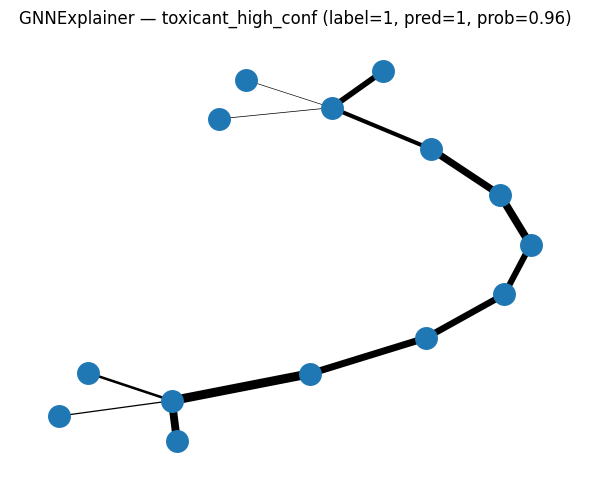

Saved: gnnexplainer_nontoxic_low_conf_label0.png


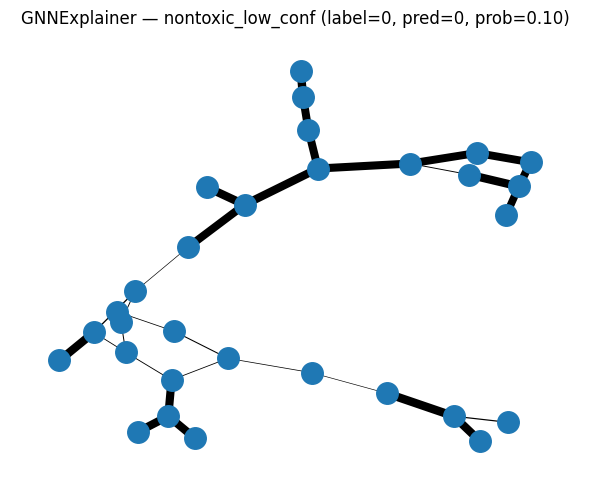

Saved: gnnexplainer_misclassified_label0.png


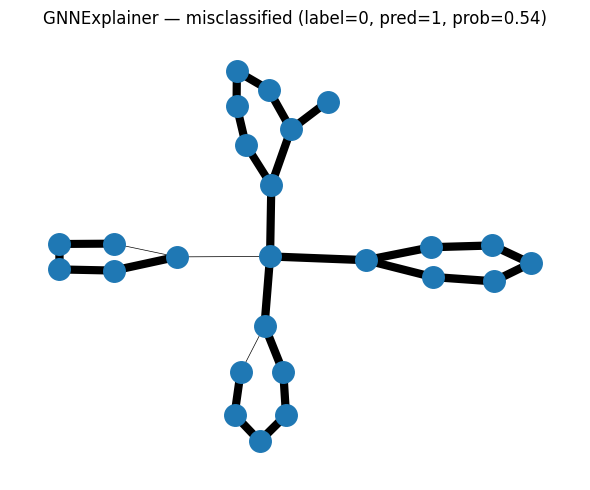

In [77]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx
from torch_geometric.explain import Explainer, GNNExplainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---- Wrap MPNN to accept (x, edge_index, edge_attr, batch) ----
class WrappedMPNN(torch.nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model
    def forward(self, x, edge_index, edge_attr=None, batch=None):
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch)
        return self.base(data)

wrapped_model = WrappedMPNN(final_model).to(device)
wrapped_model.eval()

# ---- test data/loader ----
if 'test_graphs' in globals():
    test_dataset = test_graphs
    test_loader_for_probs = DataLoader(test_dataset, batch_size=64, shuffle=False)
elif 'test_loader' in globals():
    test_dataset = list(test_loader.dataset)
    test_loader_for_probs = test_loader
else:
    raise RuntimeError("Need test_graphs or test_loader defined before running the explainer.")

@torch.no_grad()
def get_probs(model, loader, device):
    model.eval()
    probs, labels = [], []
    for batch in loader:
        batch = batch.to(device)
        logits = model.base(batch)  # call the original model on Data batches
        if isinstance(logits, (tuple, list)): logits = logits[0]
        if logits.dim() == 2 and logits.size(1) == 1: logits = logits.squeeze(1)
        elif logits.dim() > 1: logits = logits.view(-1)
        p = torch.sigmoid(logits).cpu().numpy()
        y = batch.y.view(-1).cpu().numpy().astype(int)
        probs.extend(p.tolist()); labels.extend(y.tolist())
    return np.array(probs), np.array(labels)

probs_test, y_test = get_probs(wrapped_model, test_loader_for_probs, device)

def pick_index(labels, probs, target_label):
    idxs = np.where(labels == target_label)[0]
    if idxs.size == 0: return None
    return int(idxs[np.argmax(probs[idxs])] if target_label==1 else idxs[np.argmin(probs[idxs])])

idx_pos = pick_index(y_test, probs_test, 1)
idx_neg = pick_index(y_test, probs_test, 0)
print(f"Picked indices — toxicant: {idx_pos}, non-toxicant: {idx_neg}")

# ---- Building Explainer (new API) ----
explainer = Explainer(
    model=wrapped_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw',   # your model returns logits
    ),
)

def undirected_edge_importance(edge_index, edge_mask):
    ei = edge_index.detach().cpu().numpy()
    em = edge_mask.detach().cpu().numpy().astype(float)
    imp = {}
    for k in range(ei.shape[1]):
        u, v = int(ei[0,k]), int(ei[1,k])
        a, b = min(u,v), max(u,v)
        imp[(a,b)] = max(em[k], imp.get((a,b), 0.0))
    return imp

def draw_explanation_graph(data, edge_mask, title="Explanation", save_path=None):
    G = to_networkx(data, to_undirected=True)
    pos = nx.spring_layout(G, seed=42)
    imp = undirected_edge_importance(data.edge_index, edge_mask)
    if imp:
        vals = np.array(list(imp.values()))
        lo, hi = np.percentile(vals,5), np.percentile(vals,95)
        rng = max(1e-6, hi-lo)
        width_map = {e: (0.5 + 5.5*(v-lo)/rng) for e,v in imp.items()}
    else:
        width_map = {}
    plt.figure(figsize=(6,5))
    nx.draw_networkx_nodes(G, pos, node_size=240)
    edges, widths = [], []
    for (u,v) in G.edges():
        key = (min(u,v), max(u,v))
        edges.append((u,v)); widths.append(width_map.get(key, 0.5))
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=widths)
    plt.title(title); plt.axis('off'); plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300); print(f"Saved: {save_path}")
    plt.show()

@torch.no_grad()
def predict_prob_for_data(model, data):
    # Get probability with original model on a single Data object
    out = model.base(data.to(device))
    if isinstance(out, (tuple, list)): out = out[0]
    if out.dim() > 0: out = out.view(-1)[0]
    return torch.sigmoid(out).item()

def explain_one(idx, tag="sample"):
    if idx is None:
        print(f"[skip] No index for {tag}"); return
    data = test_dataset[idx].to(device)

    # choose target = predicted class on this molecule
    prob = predict_prob_for_data(wrapped_model, data)
    pred_class = int(prob >= 0.5)  # use your CV threshold if you prefer

    # Call explainer with tensors (wrapper will rebuild Data internally)
    kwargs = dict(
        x=data.x, edge_index=data.edge_index,
        batch=(data.batch if hasattr(data,'batch') else torch.zeros(data.x.size(0), dtype=torch.long, device=data.x.device)),
        target=pred_class
    )
    if hasattr(data, "edge_attr") and data.edge_attr is not None:
        kwargs["edge_attr"] = data.edge_attr

    explanation = explainer(**kwargs)
    edge_mask = explanation.edge_mask

    title = f"GNNExplainer — {tag} (label={int(data.y.item())}, pred={pred_class}, prob={prob:.2f})"
    out_path = f"gnnexplainer_{tag}_label{int(data.y.item())}.png"
    draw_explanation_graph(data.cpu(), edge_mask.cpu(), title=title, save_path=out_path)

# Running for a confident toxicant and non-toxicant
explain_one(idx_pos, tag="toxicant_high_conf")
explain_one(idx_neg, tag="nontoxic_low_conf")

# explaining a misclassified example
preds_test = (probs_test >= 0.5).astype(int)
mis_idx = np.where(preds_test != y_test)[0]
if mis_idx.size > 0:
    explain_one(int(mis_idx[0]), tag="misclassified")


### GNNExplainer Inference

🧪 Test graph #0: P(non-toxic)=0.639, P(toxic)=0.361 → Pred=0

🔝 Top-10 atom importances (idx: score):
  Atom 6 : 3.0349
  Atom 9 : 2.1778
  Atom 1 : 2.1441
  Atom 3 : 2.0339
  Atom 7 : 1.8631
  Atom 4 : 1.3591
  Atom 8 : 1.1817
  Atom 5 : 1.1615
  Atom 10 : 1.0002
  Atom 0 : 1.0001


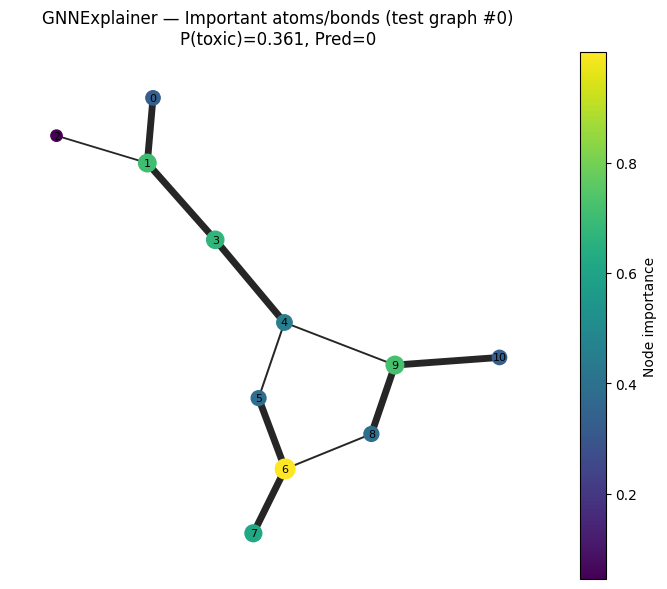

In [103]:
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.explain.config import ModelConfig
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # your trained graph model (e.g., MPNN3/GINE/GATv2)

# ---- Wrapper returns 2-class probabilities [P(y=0), P(y=1)] ----
class GraphBinaryWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model

    def forward(self, x, edge_index, edge_attr=None, batch=None):
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, batch=batch)
        logits = self.base(data)              # [B] or [B,1]
        if isinstance(logits, (tuple, list)):
            logits = logits[0]
        if logits.dim() == 2 and logits.size(1) == 1:
            logits = logits.squeeze(1)
        probs_pos = torch.sigmoid(logits).view(-1, 1)        # P(y=1)
        probs = torch.cat([1.0 - probs_pos, probs_pos], 1)   # [B, 2]
        return probs

wrapped = GraphBinaryWrapper(model).to(device)

# ---- Explainer ----
explainer = Explainer(
    model=wrapped,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',   # learn a mask over node features
    edge_mask_type='object',       # learn a mask over edges (which bonds matter)
    model_config=ModelConfig(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',       # wrapper returns [B,2] probabilities
    ),
)

mol_idx = 0  # change this to select another sample from test_graphs
data = test_graphs[mol_idx].to(device)
batch_vec = getattr(data, 'batch', None)
if batch_vec is None:
    batch_vec = torch.zeros(data.x.size(0), dtype=torch.long, device=device)

# --- Forward prediction (context)
with torch.no_grad():
    probs_2c = wrapped(data.x, data.edge_index, data.edge_attr, batch_vec)  # [1,2]
    prob_non, prob_tox = probs_2c.squeeze(0).tolist()
    pred_label = int(prob_tox >= 0.5)
print(f"🧪 Test graph #{mol_idx}: P(non-toxic)={prob_non:.3f}, P(toxic)={prob_tox:.3f} → Pred={pred_label}")

# --- Compute explanation
explanation = explainer(
    x=data.x,
    edge_index=data.edge_index,
    edge_attr=data.edge_attr,
    batch=batch_vec
)

# --- Get masks
edge_mask = explanation.edge_mask.detach().cpu().numpy()      # importance per (directed) edge
edge_index = data.edge_index.detach().cpu().numpy()
N = data.x.size(0)

# Derive node importance by summing adjacent edge importances
node_imp = np.zeros(N, dtype=float)
for e_idx in range(edge_index.shape[1]):
    i, j = edge_index[:, e_idx]
    w = edge_mask[e_idx]
    node_imp[i] += w
    node_imp[j] += w

def _safe_norm(v):
    v = np.asarray(v, dtype=float)
    vmax = np.max(v)
    return v / (vmax + 1e-8) if vmax > 0 else v

node_imp_n = _safe_norm(node_imp)
edge_imp_n = _safe_norm(edge_mask)

# --- Top-k atoms
k = min(10, N)
topk_idx = np.argsort(-node_imp)[:k]
print(f"\n🔝 Top-{k} atom importances (idx: score):")
for idx in topk_idx:
    print(f"  Atom {int(idx)} : {node_imp[idx]:.4f}")

# --- Visualizing important atoms/bonds
G = to_networkx(data, to_undirected=True, node_attrs=None, edge_attrs=None)
pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(7,6))
node_sizes = 200 * (0.3 + 0.7 * node_imp_n)
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_imp_n, cmap='viridis')

# Converting directed edge mask -> undirected (max of both directions)
edge_w = {}
for e_idx in range(edge_index.shape[1]):
    i, j = int(edge_index[0, e_idx]), int(edge_index[1, e_idx])
    key = tuple(sorted((i, j)))
    edge_w[key] = max(edge_w.get(key, 0.0), edge_imp_n[e_idx])

edge_list = list(edge_w.keys())
edge_widths = [1.0 + 4.0 * edge_w[e] for e in edge_list]
nx.draw_networkx_edges(G, pos, edgelist=edge_list, width=edge_widths, alpha=0.85)
nx.draw_networkx_labels(G, pos, labels={i: str(i) for i in range(N)}, font_size=8)

plt.title(
    f"GNNExplainer — Important atoms/bonds (test graph #{mol_idx})\n"
    f"P(toxic)={prob_tox:.3f}, Pred={pred_label}"
)
cbar = plt.colorbar(nodes); cbar.set_label("Node importance")
plt.axis('off'); plt.tight_layout(); plt.show()


### Evaluation Test Metrics Comparison Table

In [124]:
import pandas as pd

# ---- Building the table ----
data = [
    ("Balanced Accuracy",    0.7552, 0.7615, 0.7708),
    ("MCC",                  0.5104, 0.4876, 0.5521),
    ("F1 Score",             0.8438, 0.7636, 0.8615),
    ("Precision",            0.8438, 0.9130, 0.8485),
    ("Recall (Sensitivity)", 0.8438, 0.6562, 0.8750),
    ("Specificity",          0.6667, 0.8667, 0.6667),
    ("ROC AUC",              0.8500, 0.7750, 0.8646),
    ("PR AUC",               0.9154, 0.8582, 0.9315),
    ("Confusion Matrix",
     "TN=10, FP=5, FN=5, TP=27",
     "TN=13, FP=2, FN=11, TP=21",
     "TN=10, FP=5, FN=4, TP=28"),
]

df = pd.DataFrame(data, columns=["Metric", "GIN", "GAT", "MPNN"]).set_index("Metric")

def highlight_max(s):
    if s.name == "Confusion Matrix":  # skip CM (non-numeric)
        return [""] * len(s)
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

styled_df = df.style.apply(highlight_max, axis=1).set_caption("Model Test Metrics — GIN vs GAT vs MPNN")

display(styled_df)


,GIN,GAT,MPNN
Metric,,,
Balanced Accuracy,0.755200,0.761500,0.770800
MCC,0.510400,0.487600,0.552100
F1 Score,0.843800,0.763600,0.861500
Precision,0.843800,0.913000,0.848500
Recall (Sensitivity),0.843800,0.656200,0.875000
Specificity,0.666700,0.866700,0.666700
ROC AUC,0.850000,0.775000,0.864600
PR AUC,0.915400,0.858200,0.931500
Confusion Matrix,"TN=10, FP=5, FN=5, TP=27","TN=13, FP=2, FN=11, TP=21","TN=10, FP=5, FN=4, TP=28"


### Evaluation Test Metrics Comparison using Radar Chart

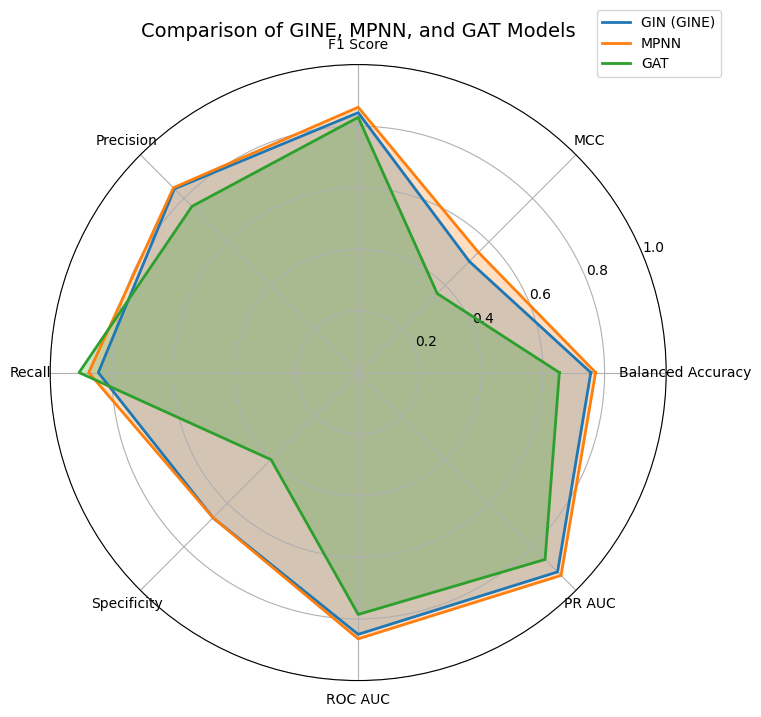

In [130]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and results
metrics = ["Balanced Accuracy", "MCC", "F1 Score", "Precision", "Recall", "Specificity", "ROC AUC", "PR AUC"]

gin  = [0.7552, 0.5104, 0.8438, 0.8438, 0.8438, 0.6667, 0.8500, 0.9154]
mpnn = [0.7708, 0.5521, 0.8615, 0.8485, 0.8750, 0.6667, 0.8646, 0.9315]
gat  = [0.6531, 0.3628, 0.8286, 0.7632, 0.9062, 0.4000, 0.7854, 0.8582]  

# Radar chart setup
labels = np.array(metrics)
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Values must also be closed 
gin  += gin[:1]
mpnn += mpnn[:1]
gat  += gat[:1]

# Creating polar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plotting each model
ax.plot(angles, gin,  linewidth=2, linestyle='solid', label='GIN (GINE)')
ax.fill(angles, gin,  alpha=0.25)

ax.plot(angles, mpnn, linewidth=2, linestyle='solid', label='MPNN')
ax.fill(angles, mpnn, alpha=0.25)

ax.plot(angles, gat,  linewidth=2, linestyle='solid', label='GAT')
ax.fill(angles, gat,  alpha=0.25)

# Fixing labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax.set_ylim(0,1)

plt.title("Comparison of GINE, MPNN, and GAT Models", size=14, pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()


### Evaluation Test Metrics Comparison using Bar Chart

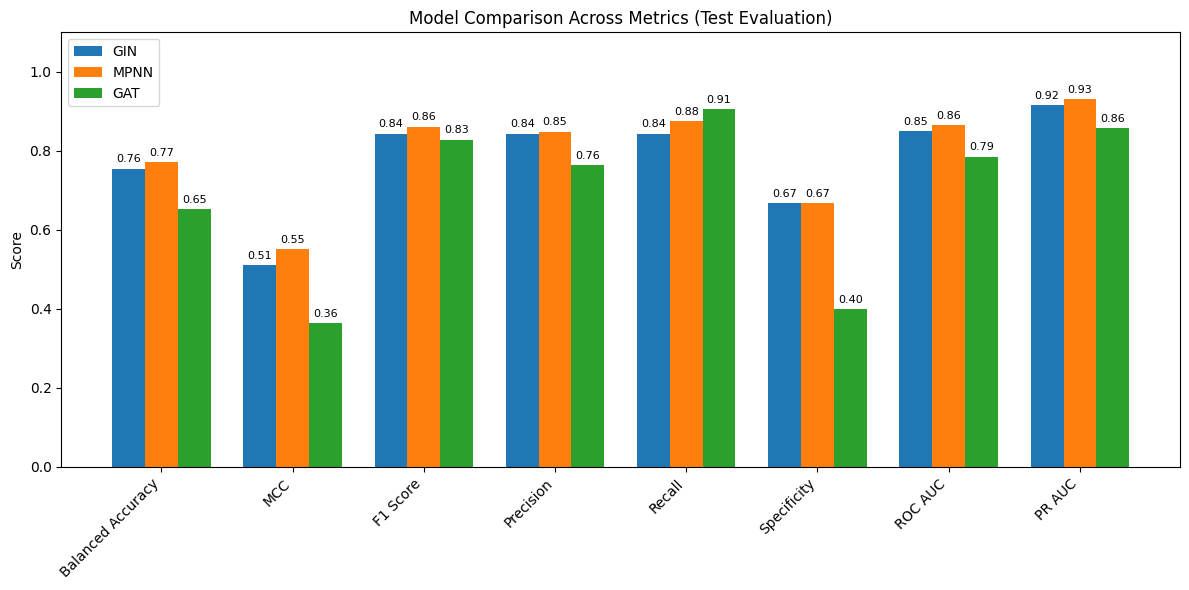

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and results
metrics = ["Balanced Accuracy", "MCC", "F1 Score", "Precision", "Recall", "Specificity", "ROC AUC", "PR AUC"]

gin  = [0.7552, 0.5104, 0.8438, 0.8438, 0.8438, 0.6667, 0.8500, 0.9154]
mpnn = [0.7708, 0.5521, 0.8615, 0.8485, 0.8750, 0.6667, 0.8646, 0.9315]
gat  = [0.6531, 0.3628, 0.8286, 0.7632, 0.9062, 0.4000, 0.7854, 0.8582]

x = np.arange(len(metrics))  # label positions
width = 0.25  # bar width

fig, ax = plt.subplots(figsize=(12,6))

# Plot bars
bars1 = ax.bar(x - width, gin, width, label='GIN')
bars2 = ax.bar(x, mpnn, width, label='MPNN')
bars3 = ax.bar(x + width, gat, width, label='GAT')

# Annotate bars
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

annotate_bars(bars1)
annotate_bars(bars2)
annotate_bars(bars3)

# Labels and formatting
ax.set_ylabel('Score')
ax.set_title('Model Comparison Across Metrics (Test Evaluation)')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha="right")
ax.set_ylim(0, 1.1)
ax.legend()

plt.tight_layout()
plt.show()


### Comparison on Cross Validation using Bar Chart

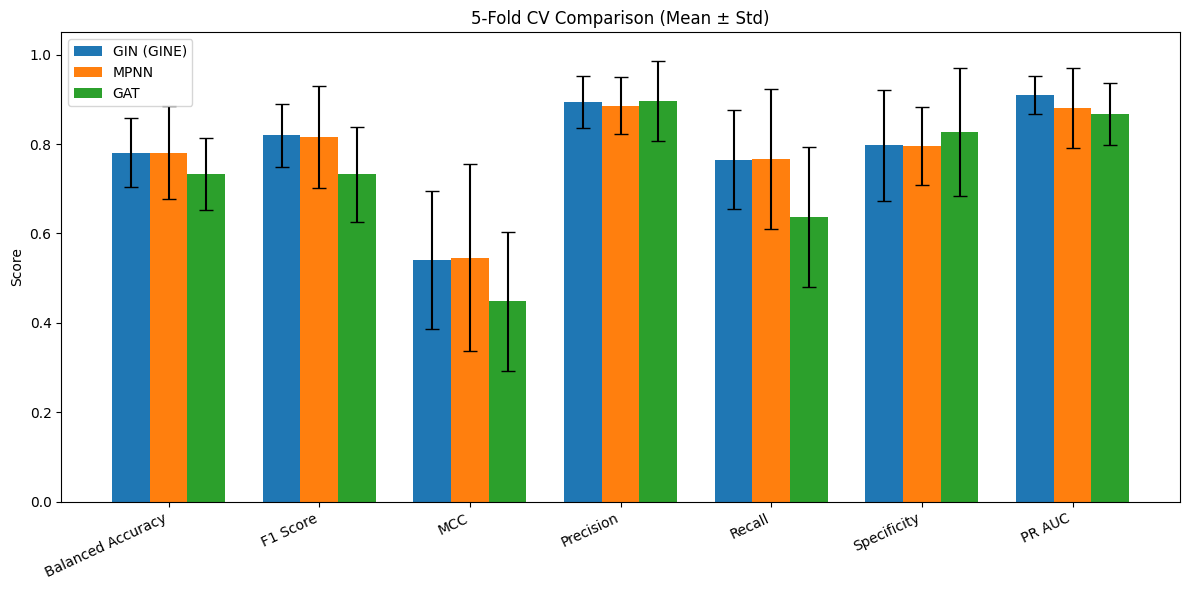

In [120]:
import numpy as np
import matplotlib.pyplot as plt

# Metrics to compare 
metrics = ["Balanced Accuracy","F1 Score","MCC","Precision","Recall","Specificity","PR AUC"]
x = np.arange(len(metrics))
width = 0.25

# ---- CV MEANS ----

gin_mean   = [0.7809, 0.8194, 0.5415, 0.8941, 0.7649, 0.7970, 0.9097]
mpnn_mean  = [0.7807, 0.8158, 0.5461, 0.8858, 0.7658, 0.7955, 0.8808]  # fixed PR AUC
gat_mean   = [0.7321, 0.7321, 0.4481, 0.8956, 0.6375, 0.8267, 0.8673]

# ---- CV STDs ----

gin_std    = [0.0769, 0.0705, 0.1544, 0.0583, 0.1106, 0.1241, 0.0423]
mpnn_std   = [0.1045, 0.1146, 0.2100, 0.0640, 0.1564, 0.0881, 0.0891]
gat_std    = [0.0807, 0.1064, 0.1558, 0.0892, 0.1564, 0.1436, 0.0699]

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width, gin_mean, width, yerr=gin_std, capsize=5, label="GIN (GINE)")
ax.bar(x,         mpnn_mean, width, yerr=mpnn_std, capsize=5, label="MPNN")
ax.bar(x + width, gat_mean, width, yerr=gat_std, capsize=5, label="GAT")

ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=25, ha="right")
ax.set_ylabel("Score")
ax.set_title("5-Fold CV Comparison (Mean ± Std)")
ax.set_ylim(0, 1.05)
ax.legend()
plt.tight_layout()
plt.show()


### Comparison on Cross Validation using Radar Chart

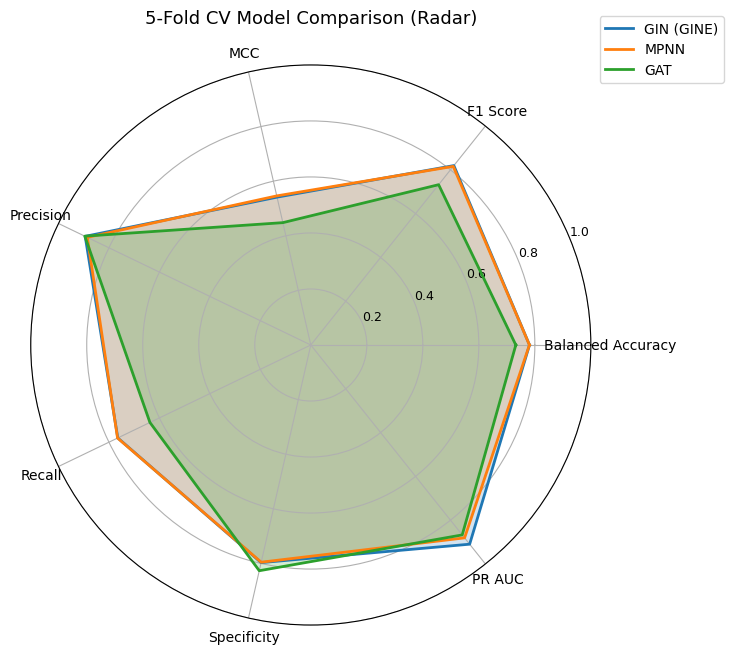

In [122]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ["Balanced Accuracy","F1 Score","MCC","Precision","Recall","Specificity","PR AUC"]
gin_mean   = [0.7809, 0.8194, 0.5415, 0.8941, 0.7649, 0.7970, 0.9097]
mpnn_mean  = [0.7807, 0.8158, 0.5461, 0.8858, 0.7658, 0.7955, 0.8808]
gat_mean   = [0.7321, 0.7321, 0.4481, 0.8956, 0.6375, 0.8267, 0.8673]

labels = np.array(metrics)
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

def closed(vals): 
    return vals + vals[:1]

fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))

# Plotting GIN
ax.plot(angles, closed(gin_mean), linewidth=2, label="GIN (GINE)")
ax.fill(angles, closed(gin_mean), alpha=0.2)

# Plotting MPNN
ax.plot(angles, closed(mpnn_mean), linewidth=2, label="MPNN")
ax.fill(angles, closed(mpnn_mean), alpha=0.2)

# Plotting GAT
ax.plot(angles, closed(gat_mean), linewidth=2, label="GAT")
ax.fill(angles, closed(gat_mean), alpha=0.2)

# Axis labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10, ha="center", va="center")
ax.set_yticks([0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(["0.2","0.4","0.6","0.8","1.0"], fontsize=9)

# Adding extra padding to the title
plt.title("5-Fold CV Model Comparison (Radar)", pad=30, fontsize=13)

# Adjusting layout to avoid overlap
plt.tight_layout(rect=[0,0,1,0.95])

# Legend
ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))

plt.show()


### Comparison of TIRESIA Paper vs MPNN Model

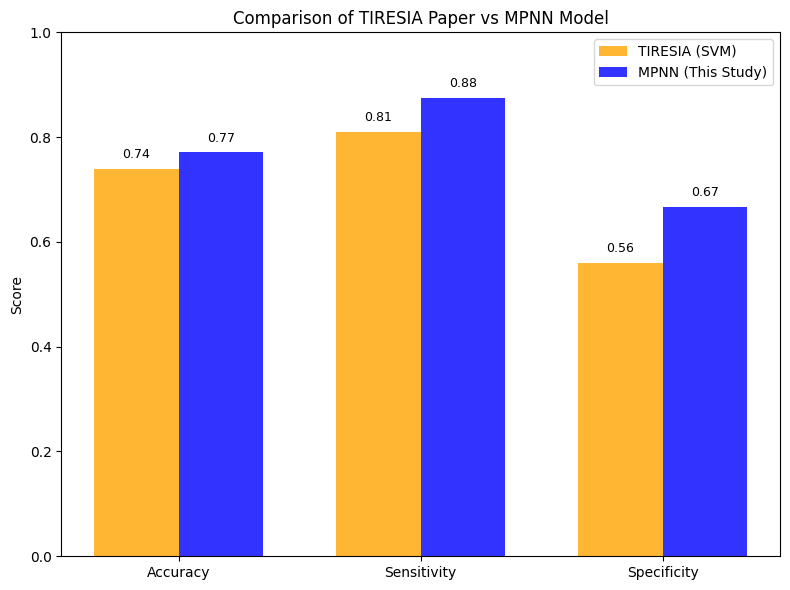

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# TIRESIA paper (SVM) results
tiresia_metrics = {
    "Accuracy": 0.74,
    "Sensitivity": 0.81,
    "Specificity": 0.56
}

# MPNN results
mpnn_metrics = {
    "Accuracy": 0.7708,        # Balanced Accuracy as proxy for Accuracy
    "Sensitivity": 0.8750,     # Recall
    "Specificity": 0.6667
}

# Metrics order
metrics = list(tiresia_metrics.keys())
tiresia_vals = [tiresia_metrics[m] for m in metrics]
mpnn_vals = [mpnn_metrics[m] for m in metrics]

# X positions
x = np.arange(len(metrics))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(8,6))

# TIRESIA paper bars
ax.bar(x - width/2, tiresia_vals, width, label="TIRESIA (SVM)", color="orange", alpha=0.8)

# MPNN bars
ax.bar(x + width/2, mpnn_vals, width, label="MPNN (This Study)", color="blue", alpha=0.8)

# Formatting
ax.set_ylabel("Score")
ax.set_title("Comparison of TIRESIA Paper vs MPNN Model")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.0)
ax.legend()

# Annotate values on bars
for i, v in enumerate(tiresia_vals):
    ax.text(i - width/2, v + 0.02, f"{v:.2f}", ha="center", fontsize=9, color="black")
for i, v in enumerate(mpnn_vals):
    ax.text(i + width/2, v + 0.02, f"{v:.2f}", ha="center", fontsize=9, color="black")

plt.tight_layout()
plt.show()
